## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'agriVision-full' 
TRANSFORM = 'fourier'
CHANNEL = 'gray'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_fourier_full_agriVision.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/agriVision/full/fourier/gray'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 45000,
 3: 72000,
 4: 63000,
 5: 117000,
 6: 126000,
 7: 171000,
 8: 189000,
 9: 297000,
 10: 396000,
 11: 495000,
 12: 648000,
 13: 882000,
 14: 1134000,
 15: 1539000,
 16: 1953000,
 17: 2574000,
 18: 3456000,
 19: 4563000,
 20: 5967000,
 21: 8010000,
 22: 10395000,
 23: 13887000,
 24: 18297000,
 25: 24057000,
 26: 31968000,
 27: 42183000,
 28: 55764000,
 29: 73701000,
 30: 97326000,
 31: 108342000,
 32: 59634000,
 33: 21420000}

Running 12760 CDFs


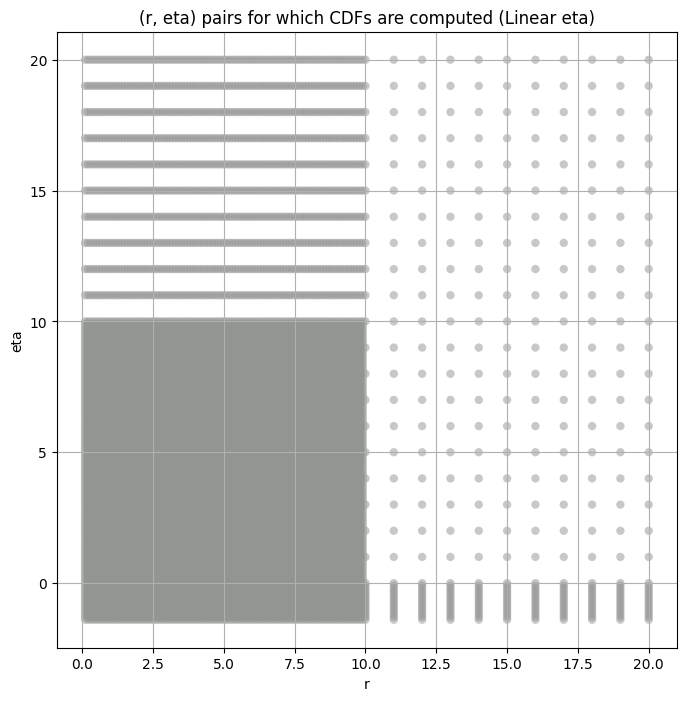

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


100%|██████████| 100000/100000 [00:44<00:00, 2237.65it/s]


Band 5


100%|██████████| 100000/100000 [00:45<00:00, 2212.25it/s]


Band 8


100%|██████████| 100000/100000 [00:43<00:00, 2293.80it/s]


Band 11


100%|██████████| 100000/100000 [00:47<00:00, 2116.99it/s]


Band 14


100%|██████████| 100000/100000 [00:46<00:00, 2134.20it/s]


Band 17


100%|██████████| 100000/100000 [00:47<00:00, 2114.72it/s]


Band 20


100%|██████████| 100000/100000 [00:46<00:00, 2140.52it/s]


Band 23


100%|██████████| 100000/100000 [00:42<00:00, 2379.93it/s]


Band 26


100%|██████████| 100000/100000 [00:42<00:00, 2348.53it/s]


Band 29


100%|██████████| 100000/100000 [00:46<00:00, 2147.42it/s]


Band 32


100%|██████████| 100000/100000 [00:43<00:00, 2315.08it/s]


obs_var   var_lower    var_upper     obs_kurt  kurt_lower  \
band                                                                 
2     986.118300  606.263600  1555.946500    356.08157   99.133300   
5     583.566700  329.252300  1187.514300    813.59064  103.779990   
8     195.376500  114.556244   365.574200    612.80610   92.325806   
11    117.897670   48.120650   487.721070   5769.23900   83.057900   
14     40.271010   20.443539   131.923110   2610.08280   75.710780   
17     24.611858    9.834547   129.458800  11181.92200   65.416466   
20     13.320553    5.668727    65.310080   6724.62650   70.291565   
23      6.579030    2.254869    43.818960  16738.59000   63.702858   
26      3.989165    0.647688    40.324917  32596.10400   71.612460   
29      0.426806    0.081010     3.450923  26453.19300   91.602455   
32      0.015853    0.008302     0.044247   1816.90760   91.580090   

      kurt_upper  total_samples  
band                             
2       600.4443        45000.0  
5      2060.5480       117000.0  
8      1727.8018       189000.0  
11     6259.8403       495000.0  
14     4860.0464      1134000.0  
17     7685.5044      2574000.0  
20     6708.6846      5967000.0  
23     8285.5580     13887000.0  
26     9318.7330     31968000.0  
29     9072.5770     73701000.0  
32     3932.4010     59634000.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                              
2     986.118300     986.118286      527.144897      415.480621   
5     583.566700     583.566711      351.214325      293.240875   
8     195.376500     195.376495      122.219139      103.375656   
11    117.897670     117.897667       50.803547       43.190105   
14     40.271010      40.271011       21.620678       18.509584   
17     24.611858      24.611858       10.372415        8.980819   
20     13.320553      13.320553        6.002163        5.169703   
23      6.579030       6.579030        2.372857        2.062163   
26      3.989165       3.989166        0.683036        0.588150   
29      0.426806       0.426806        0.085976        0.072069   
32      0.015853       0.015853        0.008759        0.007328   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2         358.278656       321.252411       277.790558       251.658722   
5         257.166168       232.934296       199.840027       178.505127   
8          91.541519        83.230324        72.218895        65.291992   
11         38.718033        35.635345        31.503202        28.783766   
14         16.678082        15.415300        13.764429        12.716779   
17          8.162703         7.598533         6.860110         6.389867   
20          4.677099         4.339134         3.895818         3.610754   
23          1.876152         1.748962         1.581960         1.474000   
26          0.532411         0.494131         0.443637         0.410601   
29          0.064274         0.059163         0.052683         0.048547   
32          0.006549         0.006049         0.005425         0.005024   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2          232.439148       217.439377       205.033997       177.416779  
5          163.050369       151.395111       142.240265       122.886124  
8           60.323715        56.491871        53.342110        46.568325  
11          26.843023        25.356552        24.163538        21.592682  
14          11.965663        11.392713        10.933157         9.931814  
17           6.054447         5.796036         5.585386         5.120851  
20           3.406793         3.249690         3.121987         2.838699  
23           1.395334         1.333177         1.281515         1.163122  
26           0.386302         0.367093         0.351157         0.314779  
29           0.045514         0.043103         0.041092         0.036482  
32           0.004725         0.004485         0.004282         0.003809

####
Band  2


100%|██████████| 12760/12760 [00:24<00:00, 519.01it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.03235493950201604 986.1183


100%|██████████| 12760/12760 [00:19<00:00, 643.08it/s]


Finding Minimum after computing 12760 CDFs
2 25 0.02145777885034815 527.1449


100%|██████████| 12760/12760 [00:20<00:00, 633.24it/s]


Finding Minimum after computing 12760 CDFs
2 50 0.0152476137397497 415.48062


100%|██████████| 12760/12760 [00:19<00:00, 654.47it/s]


Finding Minimum after computing 12760 CDFs
2 75 0.01296538460817627 358.27866


100%|██████████| 12760/12760 [00:19<00:00, 646.62it/s]


Finding Minimum after computing 12760 CDFs
2 100 0.011315230132720927 321.2524


100%|██████████| 12760/12760 [00:19<00:00, 646.57it/s]


Finding Minimum after computing 12760 CDFs
2 150 0.009021084565808968 277.79056


100%|██████████| 12760/12760 [00:19<00:00, 646.78it/s]


Finding Minimum after computing 12760 CDFs
2 200 0.008541632053511439 251.65872


100%|██████████| 12760/12760 [00:19<00:00, 648.32it/s]


Finding Minimum after computing 12760 CDFs
2 250 0.009902724091209958 232.43915


100%|██████████| 12760/12760 [00:19<00:00, 650.75it/s]


Finding Minimum after computing 12760 CDFs
2 300 0.011199996571978899 217.43938


100%|██████████| 12760/12760 [00:19<00:00, 653.23it/s]


Finding Minimum after computing 12760 CDFs
2 350 0.012470721479131197 205.034


100%|██████████| 12760/12760 [00:19<00:00, 643.78it/s]


Finding Minimum after computing 12760 CDFs
2 500 0.01613899605772262 177.41678
Number of samples: 45000, Without approximation : 45000.0


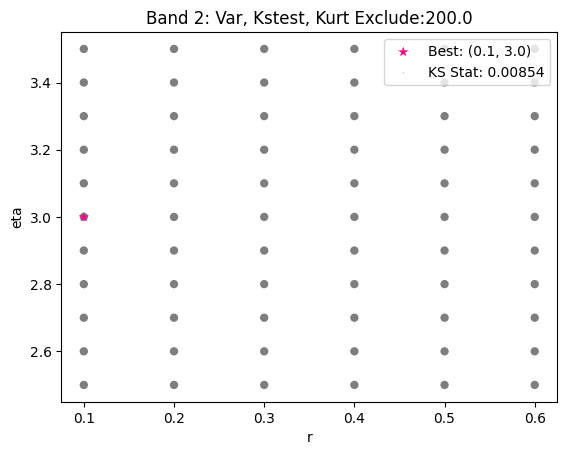

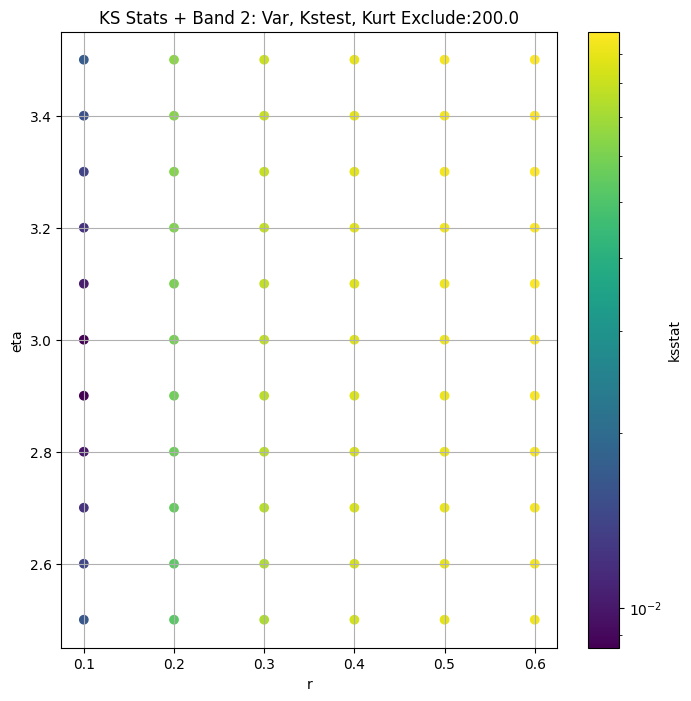

####
Band  5


100%|██████████| 12760/12760 [00:43<00:00, 292.30it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.03424634932466743 583.5667


100%|██████████| 12760/12760 [00:47<00:00, 270.85it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.027443943248597696 351.21432


100%|██████████| 12760/12760 [00:44<00:00, 286.18it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.023382393176389446 293.24088


100%|██████████| 12760/12760 [00:43<00:00, 292.03it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.021040533940100026 257.16617


100%|██████████| 12760/12760 [00:43<00:00, 295.59it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.01770741061539384 232.9343


100%|██████████| 12760/12760 [00:43<00:00, 296.48it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.014894177032902203 199.84003


100%|██████████| 12760/12760 [00:43<00:00, 296.61it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.012723425757424411 178.50513


100%|██████████| 12760/12760 [00:43<00:00, 291.74it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.011352371805699868 163.05037


100%|██████████| 12760/12760 [00:43<00:00, 290.33it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.009598566885301363 151.39511


100%|██████████| 12760/12760 [00:43<00:00, 291.15it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.008446836781226041 142.24026


100%|██████████| 12760/12760 [00:47<00:00, 269.34it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.007594333979055179 122.88612
Number of samples: 100000, Without approximation : 117000.0


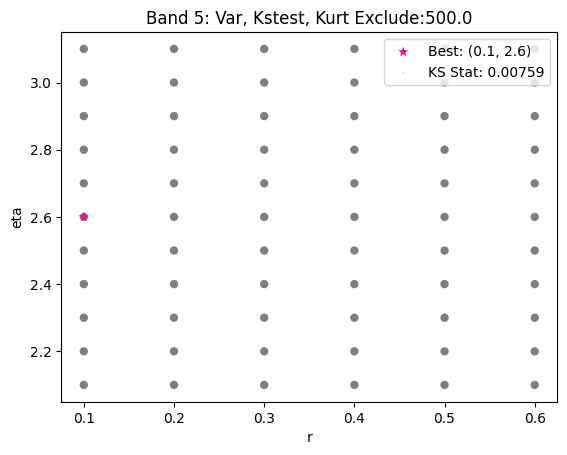

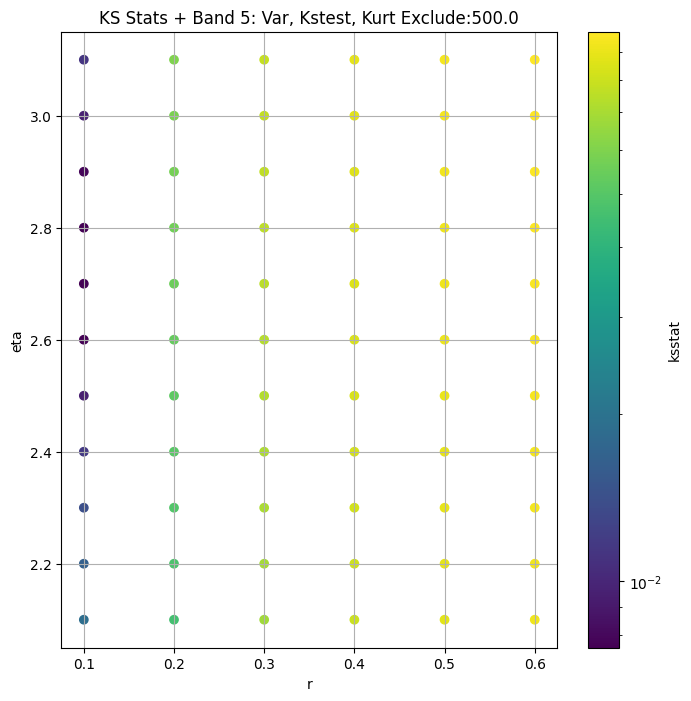

####
Band  8


100%|██████████| 12760/12760 [00:43<00:00, 291.02it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.0346727659803896 195.3765


100%|██████████| 12760/12760 [00:43<00:00, 292.57it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.02573778565679191 122.21914


100%|██████████| 12760/12760 [00:43<00:00, 291.45it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.021935479680492254 103.375656


100%|██████████| 12760/12760 [00:50<00:00, 254.93it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.019734879927719162 91.54152


100%|██████████| 12760/12760 [00:43<00:00, 291.96it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.017522971937010023 83.23032


100%|██████████| 12760/12760 [00:48<00:00, 263.49it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.013740395147783135 72.218895


100%|██████████| 12760/12760 [00:45<00:00, 279.82it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.011572001088099082 65.29199


100%|██████████| 12760/12760 [00:44<00:00, 289.23it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.009260774796289173 60.323715


100%|██████████| 12760/12760 [00:45<00:00, 277.95it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.007976743157146318 56.49187


100%|██████████| 12760/12760 [00:44<00:00, 289.09it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.0066852084886332985 53.34211


100%|██████████| 12760/12760 [00:45<00:00, 281.77it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.007328250700508798 46.568325
Number of samples: 100000, Without approximation : 189000.0


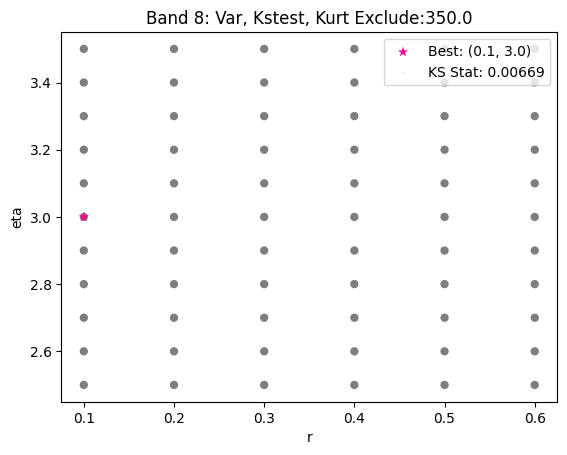

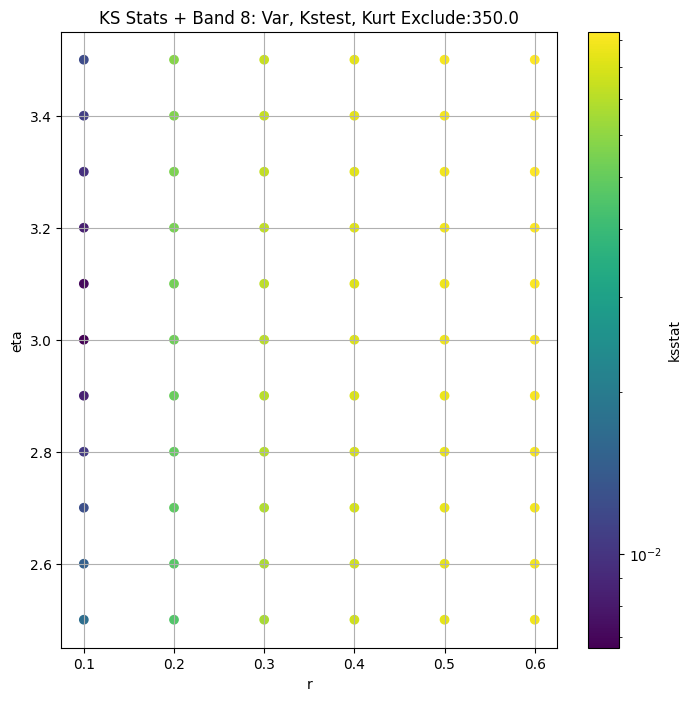

####
Band  11


100%|██████████| 12760/12760 [00:47<00:00, 268.03it/s]


Finding Minimum after computing 12760 CDFs
11 0 0.03691405634574706 117.89767


100%|██████████| 12760/12760 [00:47<00:00, 267.81it/s]


Finding Minimum after computing 12760 CDFs
11 25 0.02120510258012223 50.803547


100%|██████████| 12760/12760 [00:47<00:00, 267.13it/s]


Finding Minimum after computing 12760 CDFs
11 50 0.016728433025059705 43.190105


100%|██████████| 12760/12760 [00:50<00:00, 253.68it/s]


Finding Minimum after computing 12760 CDFs
11 75 0.014353237726832987 38.718033


100%|██████████| 12760/12760 [00:45<00:00, 279.78it/s]


Finding Minimum after computing 12760 CDFs
11 100 0.012768736294212824 35.635345


100%|██████████| 12760/12760 [00:43<00:00, 291.27it/s]


Finding Minimum after computing 12760 CDFs
11 150 0.009211674667709446 31.503202


100%|██████████| 12760/12760 [00:43<00:00, 294.94it/s]


Finding Minimum after computing 12760 CDFs
11 200 0.006856158892682096 28.783766


100%|██████████| 12760/12760 [00:43<00:00, 293.97it/s]


Finding Minimum after computing 12760 CDFs
11 250 0.005212413034151098 26.843023


100%|██████████| 12760/12760 [00:43<00:00, 295.66it/s]


Finding Minimum after computing 12760 CDFs
11 300 0.004431908724089495 25.356552


100%|██████████| 12760/12760 [00:43<00:00, 295.42it/s]


Finding Minimum after computing 12760 CDFs
11 350 0.00496384714804432 24.163538


100%|██████████| 12760/12760 [00:43<00:00, 294.36it/s]


Finding Minimum after computing 12760 CDFs
11 500 0.006782277520536728 21.592682
Number of samples: 100000, Without approximation : 495000.0


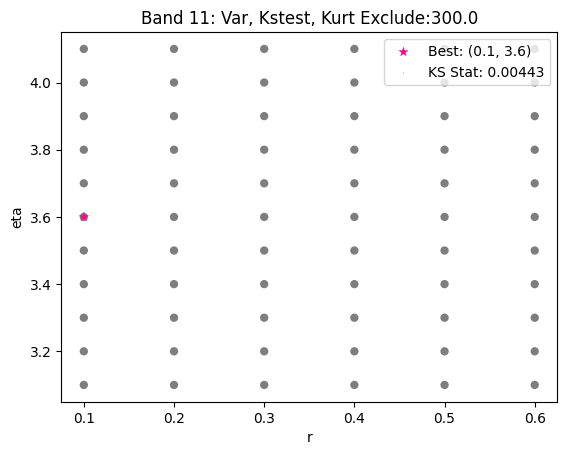

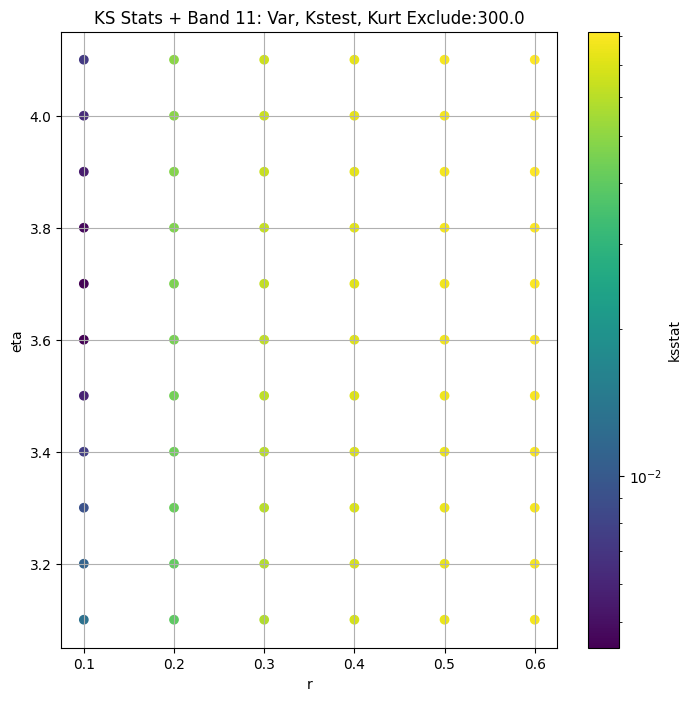

####
Band  14


100%|██████████| 12760/12760 [00:45<00:00, 281.57it/s]


Finding Minimum after computing 12760 CDFs
14 0 0.03128660316636295 40.27101


100%|██████████| 12760/12760 [00:43<00:00, 294.93it/s]


Finding Minimum after computing 12760 CDFs
14 25 0.017877166297839253 21.620678


100%|██████████| 12760/12760 [00:43<00:00, 295.22it/s]


Finding Minimum after computing 12760 CDFs
14 50 0.013884162131634237 18.509584


100%|██████████| 12760/12760 [00:44<00:00, 289.54it/s]


Finding Minimum after computing 12760 CDFs
14 75 0.011024560187635313 16.678082


100%|██████████| 12760/12760 [00:43<00:00, 295.37it/s]


Finding Minimum after computing 12760 CDFs
14 100 0.009287789363129018 15.4153


100%|██████████| 12760/12760 [00:42<00:00, 300.44it/s]


Finding Minimum after computing 12760 CDFs
14 150 0.005735532035053392 13.764429


100%|██████████| 12760/12760 [00:42<00:00, 298.88it/s]


Finding Minimum after computing 12760 CDFs
14 200 0.0036691978407619175 12.716779


100%|██████████| 12760/12760 [00:43<00:00, 295.67it/s]


Finding Minimum after computing 12760 CDFs
14 250 0.003455017346165823 11.965663


100%|██████████| 12760/12760 [00:42<00:00, 300.77it/s]


Finding Minimum after computing 12760 CDFs
14 300 0.003968444776692004 11.392713


100%|██████████| 12760/12760 [00:42<00:00, 299.44it/s]


Finding Minimum after computing 12760 CDFs
14 350 0.004577356263286481 10.933157


100%|██████████| 12760/12760 [00:42<00:00, 299.29it/s]


Finding Minimum after computing 12760 CDFs
14 500 0.006319345345494054 9.931814
Number of samples: 100000, Without approximation : 1134000.0


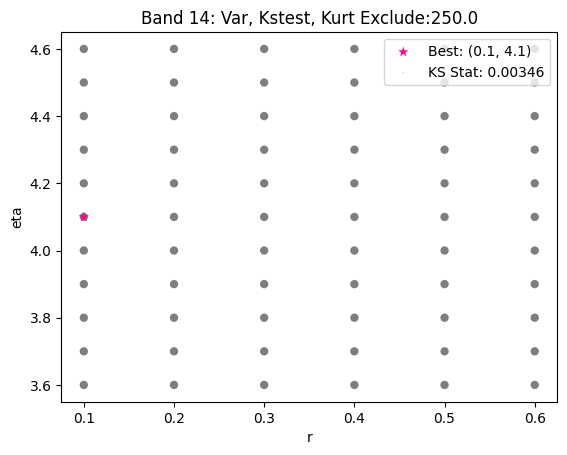

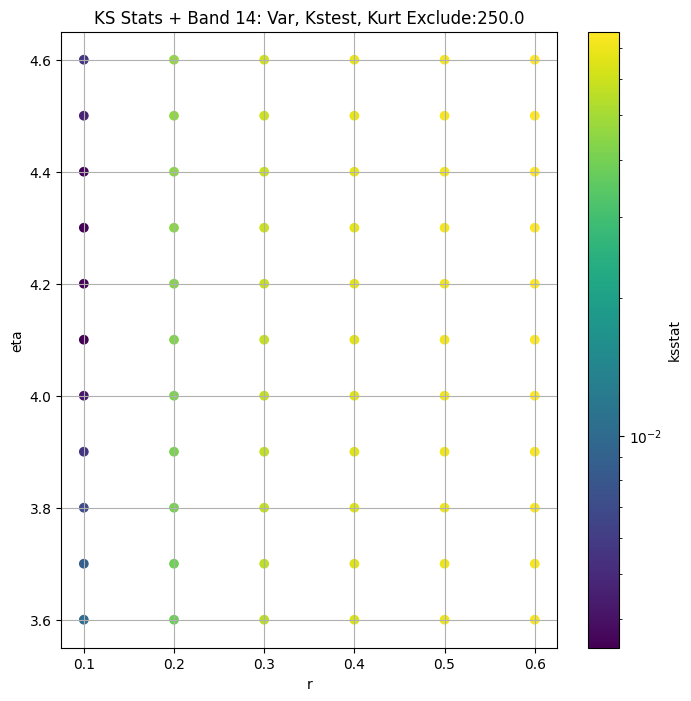

####
Band  17


100%|██████████| 12760/12760 [00:42<00:00, 298.18it/s]


Finding Minimum after computing 12760 CDFs
17 0 0.03272868665513895 24.611858


100%|██████████| 12760/12760 [00:42<00:00, 299.52it/s]


Finding Minimum after computing 12760 CDFs
17 25 0.014110214581181446 10.372415


100%|██████████| 12760/12760 [00:42<00:00, 299.34it/s]


Finding Minimum after computing 12760 CDFs
17 50 0.011005245963468191 8.980819


100%|██████████| 12760/12760 [00:43<00:00, 295.23it/s]


Finding Minimum after computing 12760 CDFs
17 75 0.007960161274847222 8.162703


100%|██████████| 12760/12760 [00:42<00:00, 299.18it/s]


Finding Minimum after computing 12760 CDFs
17 100 0.006136790423246885 7.598533


100%|██████████| 12760/12760 [00:43<00:00, 295.29it/s]


Finding Minimum after computing 12760 CDFs
17 150 0.0037296834318924776 6.86011


100%|██████████| 12760/12760 [00:42<00:00, 299.61it/s]


Finding Minimum after computing 12760 CDFs
17 200 0.002742007742790239 6.389867


100%|██████████| 12760/12760 [00:43<00:00, 296.20it/s]


Finding Minimum after computing 12760 CDFs
17 250 0.0033184769060867142 6.0544467


100%|██████████| 12760/12760 [00:44<00:00, 287.90it/s]


Finding Minimum after computing 12760 CDFs
17 300 0.004006484953259519 5.7960362


100%|██████████| 12760/12760 [00:42<00:00, 298.16it/s]


Finding Minimum after computing 12760 CDFs
17 350 0.004736452044008743 5.585386


100%|██████████| 12760/12760 [00:43<00:00, 291.10it/s]


Finding Minimum after computing 12760 CDFs
17 500 0.006597352145434322 5.1208506
Number of samples: 100000, Without approximation : 2574000.0


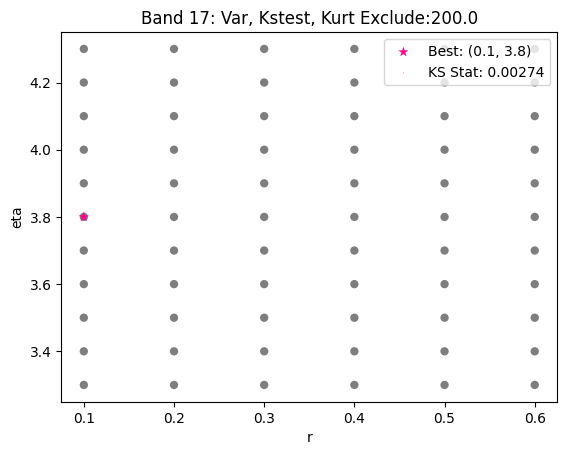

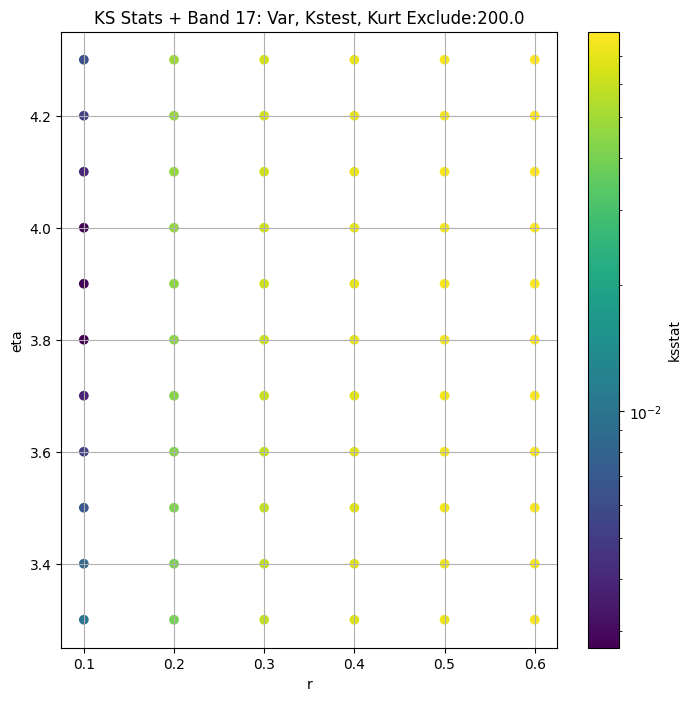

####
Band  20


100%|██████████| 12760/12760 [00:42<00:00, 302.16it/s]


Finding Minimum after computing 12760 CDFs
20 0 0.03033785912321496 13.320553


100%|██████████| 12760/12760 [00:42<00:00, 302.96it/s]


Finding Minimum after computing 12760 CDFs
20 25 0.014791585132339358 6.002163


100%|██████████| 12760/12760 [00:42<00:00, 301.54it/s]


Finding Minimum after computing 12760 CDFs
20 50 0.01149134762261167 5.169703


100%|██████████| 12760/12760 [00:42<00:00, 301.54it/s]


Finding Minimum after computing 12760 CDFs
20 75 0.008990830117100446 4.6770988


100%|██████████| 12760/12760 [00:42<00:00, 300.66it/s]


Finding Minimum after computing 12760 CDFs
20 100 0.007567990615884923 4.3391337


100%|██████████| 12760/12760 [00:42<00:00, 301.85it/s]


Finding Minimum after computing 12760 CDFs
20 150 0.004953025981255577 3.8958185


100%|██████████| 12760/12760 [00:42<00:00, 299.24it/s]


Finding Minimum after computing 12760 CDFs
20 200 0.00344366670656715 3.6107543


100%|██████████| 12760/12760 [00:42<00:00, 301.68it/s]


Finding Minimum after computing 12760 CDFs
20 250 0.003954617816433439 3.4067934


100%|██████████| 12760/12760 [00:42<00:00, 300.30it/s]


Finding Minimum after computing 12760 CDFs
20 300 0.00467752484278805 3.24969


100%|██████████| 12760/12760 [00:42<00:00, 298.89it/s]


Finding Minimum after computing 12760 CDFs
20 350 0.005283454451752871 3.121987


100%|██████████| 12760/12760 [00:43<00:00, 295.01it/s]


Finding Minimum after computing 12760 CDFs
20 500 0.007364596343260754 2.8386989
Number of samples: 100000, Without approximation : 5967000.0


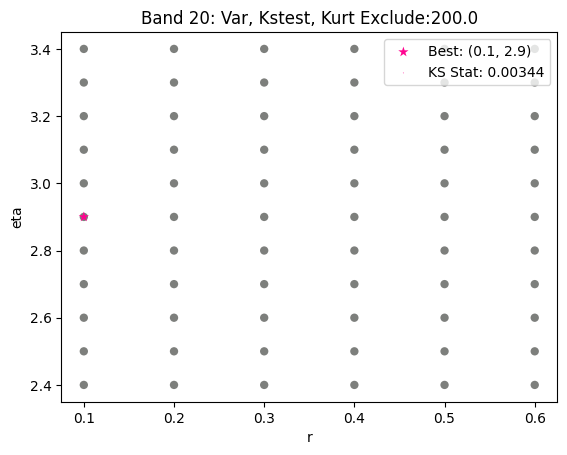

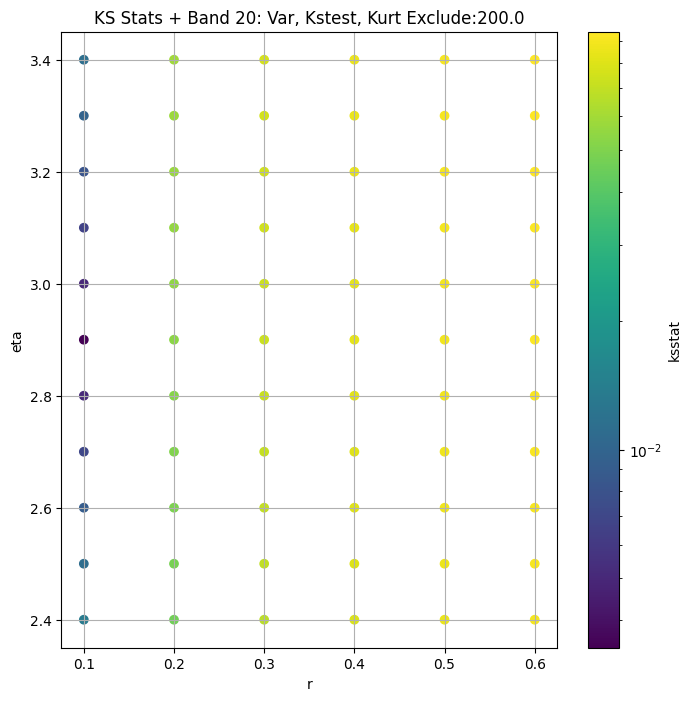

####
Band  23


100%|██████████| 12760/12760 [00:42<00:00, 302.08it/s]


Finding Minimum after computing 12760 CDFs
23 0 0.03408263329103356 6.57903


100%|██████████| 12760/12760 [00:42<00:00, 302.20it/s]


Finding Minimum after computing 12760 CDFs
23 25 0.015095323544165262 2.3728573


100%|██████████| 12760/12760 [00:43<00:00, 294.03it/s]


Finding Minimum after computing 12760 CDFs
23 50 0.01152860232840025 2.0621626


100%|██████████| 12760/12760 [00:43<00:00, 290.05it/s]


Finding Minimum after computing 12760 CDFs
23 75 0.010138039693265655 1.876152


100%|██████████| 12760/12760 [00:42<00:00, 299.63it/s]


Finding Minimum after computing 12760 CDFs
23 100 0.008219164749047492 1.7489616


100%|██████████| 12760/12760 [00:42<00:00, 299.46it/s]


Finding Minimum after computing 12760 CDFs
23 150 0.006435702273924426 1.5819596


100%|██████████| 12760/12760 [00:42<00:00, 300.95it/s]


Finding Minimum after computing 12760 CDFs
23 200 0.005335076864309174 1.4739996


100%|██████████| 12760/12760 [00:43<00:00, 295.17it/s]


Finding Minimum after computing 12760 CDFs
23 250 0.004956416462422286 1.3953336


100%|██████████| 12760/12760 [00:42<00:00, 300.11it/s]


Finding Minimum after computing 12760 CDFs
23 300 0.005892646282362635 1.3331773


100%|██████████| 12760/12760 [00:42<00:00, 302.08it/s]


Finding Minimum after computing 12760 CDFs
23 350 0.00626732058702284 1.2815145


100%|██████████| 12760/12760 [00:45<00:00, 277.83it/s]


Finding Minimum after computing 12760 CDFs
23 500 0.008197869781426115 1.163122
Number of samples: 100000, Without approximation : 13887000.0


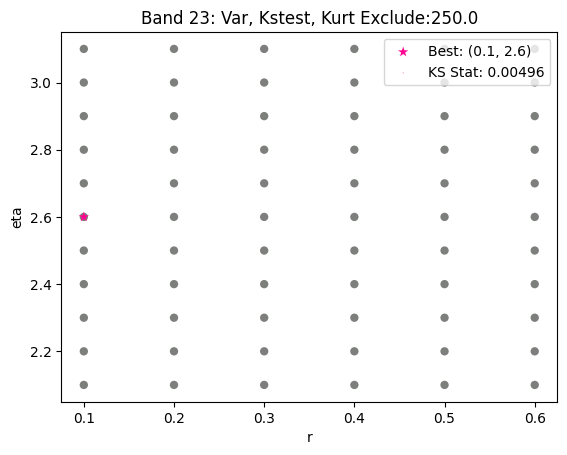

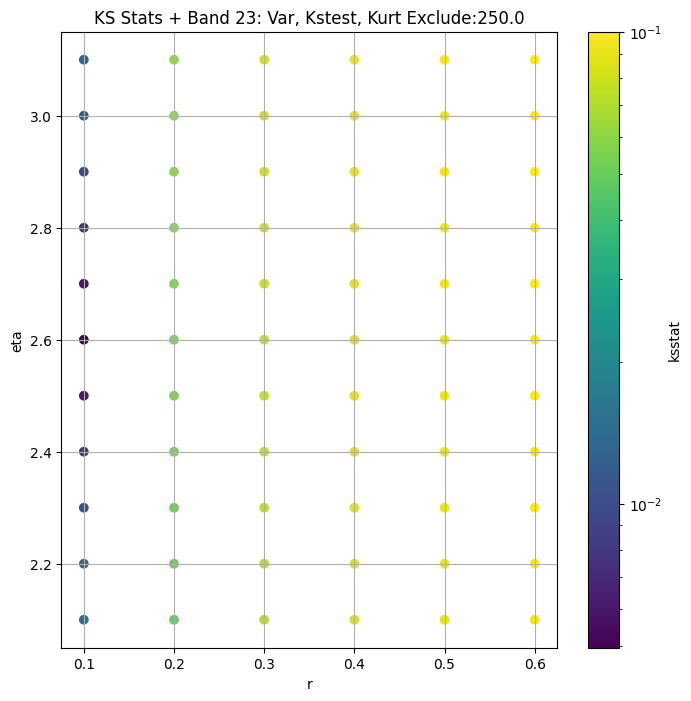

####
Band  26


100%|██████████| 12760/12760 [00:42<00:00, 298.29it/s]


Finding Minimum after computing 12760 CDFs
26 0 0.044727748953985194 3.9891655


100%|██████████| 12760/12760 [09:23<00:00, 22.65it/s]  


Finding Minimum after computing 12760 CDFs
26 25 0.01468849193963162 0.6830364


100%|██████████| 12760/12760 [42:30<00:00,  5.00it/s]  


Finding Minimum after computing 12760 CDFs
26 50 0.011575844180681583 0.5881498


100%|██████████| 12760/12760 [02:25<00:00, 87.80it/s] 


Finding Minimum after computing 12760 CDFs
26 75 0.010883476981032425 0.53241074


100%|██████████| 12760/12760 [01:15<00:00, 169.53it/s]


Finding Minimum after computing 12760 CDFs
26 100 0.008621021634964143 0.49413118


100%|██████████| 12760/12760 [01:16<00:00, 165.80it/s]


Finding Minimum after computing 12760 CDFs
26 150 0.006604710196190577 0.4436373


100%|██████████| 12760/12760 [03:23<00:00, 62.61it/s] 


Finding Minimum after computing 12760 CDFs
26 200 0.005948530229098248 0.41060108


100%|██████████| 12760/12760 [02:47<00:00, 76.23it/s] 


Finding Minimum after computing 12760 CDFs
26 250 0.0055038034929381086 0.38630214


100%|██████████| 12760/12760 [02:39<00:00, 80.05it/s] 


Finding Minimum after computing 12760 CDFs
26 300 0.006452368465045821 0.36709252


100%|██████████| 12760/12760 [02:56<00:00, 72.44it/s] 


Finding Minimum after computing 12760 CDFs
26 350 0.006596038430072504 0.35115704


100%|██████████| 12760/12760 [01:42<00:00, 123.96it/s]


Finding Minimum after computing 12760 CDFs
26 500 0.008453416423319315 0.31477895
Number of samples: 100000, Without approximation : 31968000.0


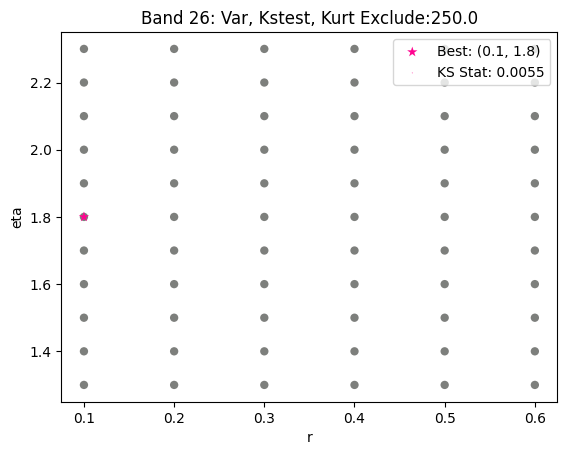

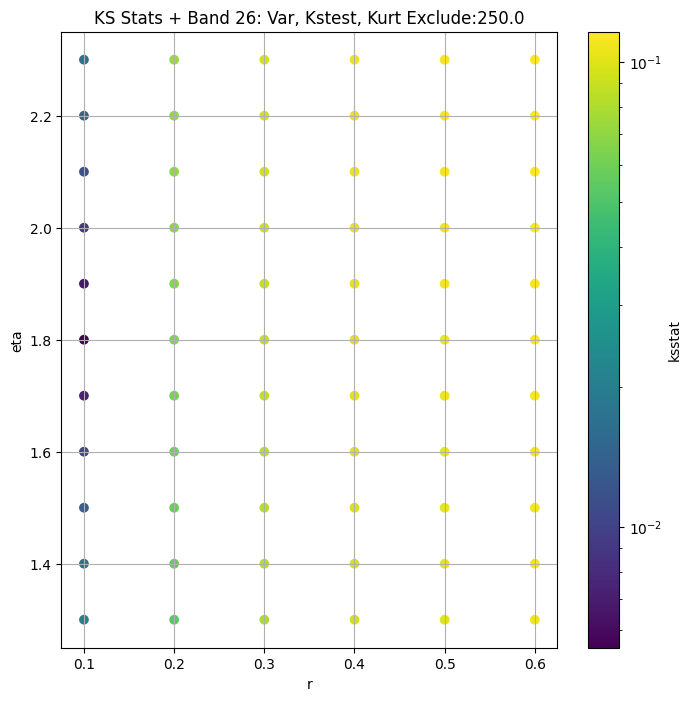

####
Band  29


100%|██████████| 12760/12760 [01:12<00:00, 175.99it/s]


Finding Minimum after computing 12760 CDFs
29 0 0.04241956678215392 0.42680618


100%|██████████| 12760/12760 [29:21<00:00,  7.25it/s]  


Finding Minimum after computing 12760 CDFs
29 25 0.019529948990643003 0.085975856


100%|██████████| 12760/12760 [01:12<00:00, 175.56it/s]


Finding Minimum after computing 12760 CDFs
29 50 0.017234147130301303 0.072068684


100%|██████████| 12760/12760 [01:11<00:00, 177.89it/s]


Finding Minimum after computing 12760 CDFs
29 75 0.01555761380779197 0.06427422


100%|██████████| 12760/12760 [01:16<00:00, 166.00it/s]


Finding Minimum after computing 12760 CDFs
29 100 0.014440771273242503 0.059163474


100%|██████████| 12760/12760 [01:12<00:00, 176.54it/s]


Finding Minimum after computing 12760 CDFs
29 150 0.01085252662548225 0.052683003


100%|██████████| 12760/12760 [01:12<00:00, 176.35it/s]


Finding Minimum after computing 12760 CDFs
29 200 0.010215362962124108 0.048547484


100%|██████████| 12760/12760 [01:15<00:00, 169.63it/s]


Finding Minimum after computing 12760 CDFs
29 250 0.009156504306437496 0.04551413


100%|██████████| 12760/12760 [01:15<00:00, 169.04it/s]


Finding Minimum after computing 12760 CDFs
29 300 0.008405450108263546 0.04310325


100%|██████████| 12760/12760 [01:21<00:00, 157.33it/s]


Finding Minimum after computing 12760 CDFs
29 350 0.00929507816977293 0.041092027


100%|██████████| 12760/12760 [01:24<00:00, 150.56it/s]


Finding Minimum after computing 12760 CDFs
29 500 0.010496639139814357 0.036482327
Number of samples: 100000, Without approximation : 73701000.0


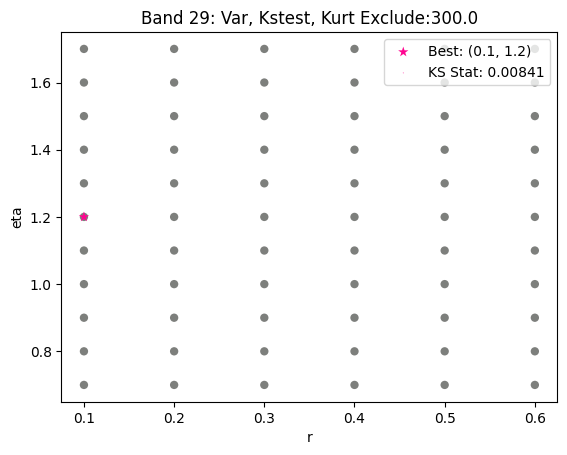

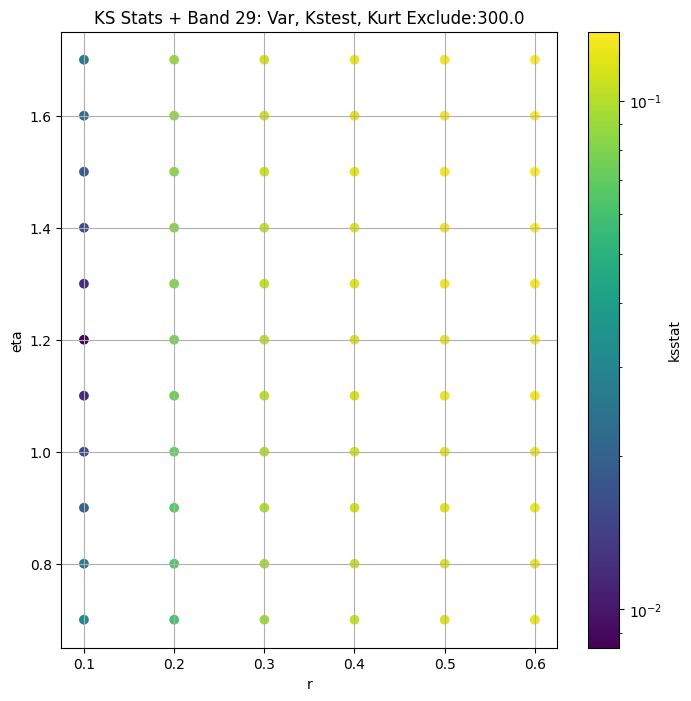

####
Band  32


100%|██████████| 12760/12760 [01:15<00:00, 169.28it/s]


Finding Minimum after computing 12760 CDFs
32 0 0.03604395493363299 0.015852839


100%|██████████| 12760/12760 [01:15<00:00, 170.05it/s]


Finding Minimum after computing 12760 CDFs
32 25 0.026259009240405307 0.008759352


100%|██████████| 12760/12760 [01:16<00:00, 166.04it/s]


Finding Minimum after computing 12760 CDFs
32 50 0.023122139729341296 0.0073281834


100%|██████████| 12760/12760 [01:15<00:00, 168.09it/s]


Finding Minimum after computing 12760 CDFs
32 75 0.019419957704400193 0.006548549


100%|██████████| 12760/12760 [01:16<00:00, 167.05it/s]


Finding Minimum after computing 12760 CDFs
32 100 0.01811266088727964 0.006048633


100%|██████████| 12760/12760 [01:13<00:00, 174.16it/s]


Finding Minimum after computing 12760 CDFs
32 150 0.016582005556138868 0.0054246155


100%|██████████| 12760/12760 [01:12<00:00, 176.55it/s]


Finding Minimum after computing 12760 CDFs
32 200 0.01531252886487744 0.0050240033


100%|██████████| 12760/12760 [01:12<00:00, 177.11it/s]


Finding Minimum after computing 12760 CDFs
32 250 0.01482160353786649 0.004725322


100%|██████████| 12760/12760 [01:14<00:00, 171.55it/s]


Finding Minimum after computing 12760 CDFs
32 300 0.01410050108173766 0.0044848244


100%|██████████| 12760/12760 [01:16<00:00, 167.08it/s]


Finding Minimum after computing 12760 CDFs
32 350 0.013275263751869104 0.00428203


100%|██████████| 12760/12760 [01:19<00:00, 160.53it/s]


Finding Minimum after computing 12760 CDFs
32 500 0.010701370871992855 0.0038094958
Number of samples: 100000, Without approximation : 59634000.0


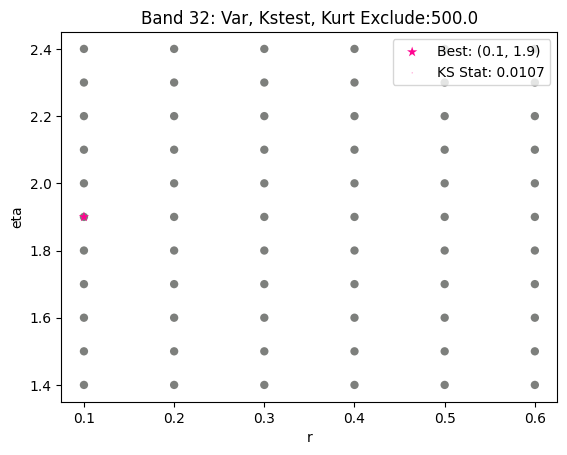

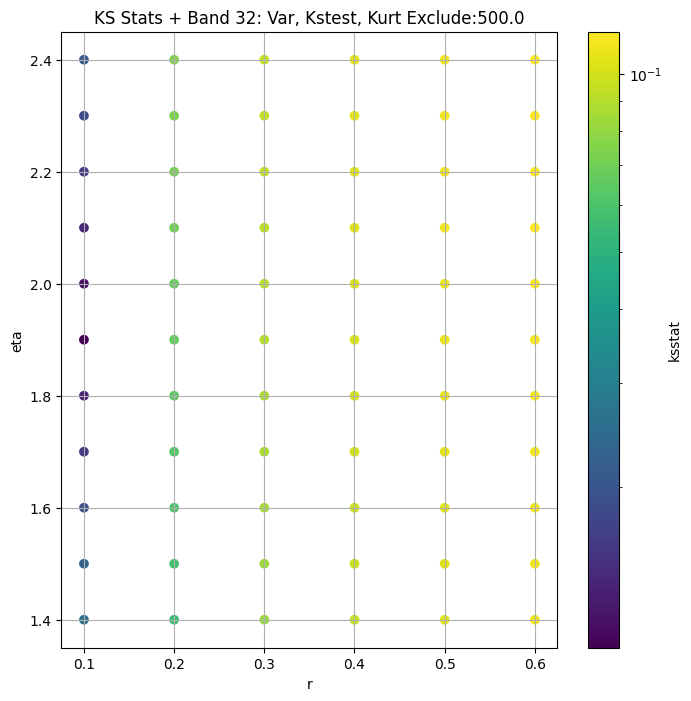

obs_var   var_lower    var_upper     obs_kurt  kurt_lower  \
band                                                                 
2     986.118300  606.263600  1555.946500    356.08157   99.133300   
5     583.566700  329.252300  1187.514300    813.59064  103.779990   
8     195.376500  114.556244   365.574200    612.80610   92.325806   
11    117.897670   48.120650   487.721070   5769.23900   83.057900   
14     40.271010   20.443539   131.923110   2610.08280   75.710780   
17     24.611858    9.834547   129.458800  11181.92200   65.416466   
20     13.320553    5.668727    65.310080   6724.62650   70.291565   
23      6.579030    2.254869    43.818960  16738.59000   63.702858   
26      3.989165    0.647688    40.324917  32596.10400   71.612460   
29      0.426806    0.081010     3.450923  26453.19300   91.602455   
32      0.015853    0.008302     0.044247   1816.90760   91.580090   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2       600.4443        45000.0             0.008542        0.1          3.0   
5      2060.5480       117000.0             0.007594        0.1          2.6   
8      1727.8018       189000.0             0.006685        0.1          3.0   
11     6259.8403       495000.0             0.004432        0.1          3.6   
14     4860.0464      1134000.0             0.003455        0.1          4.1   
17     7685.5044      2574000.0             0.002742        0.1          3.8   
20     6708.6846      5967000.0             0.003444        0.1          2.9   
23     8285.5580     13887000.0             0.004956        0.1          2.6   
26     9318.7330     31968000.0             0.005504        0.1          1.8   
29     9072.5770     73701000.0             0.008405        0.1          1.2   
32     3932.4010     59634000.0             0.010701        0.1          1.9   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      2.897966e-15                   200.0          251.658720   
5      3.296652e-15                   500.0          122.886120   
8      6.142590e-16                   350.0           53.342110   
11     9.268090e-17                   300.0           25.356552   
14     1.841990e-17                   250.0           11.965663   
17     1.637736e-17                   200.0            6.389867   
20     5.102939e-17                   200.0            3.610754   
23     3.743245e-17                   250.0            1.395334   
26     7.234702e-17                   250.0            0.386302   
29     4.672980e-17                   300.0            0.043103   
32     5.475282e-19                   500.0            0.003809   

      kstest_stat_cutoff_0.05  
band                           
2                    0.006398  
5                    0.003969  
8                    0.003123  
11                   0.001930  
14                   0.001275  
17                   0.000846  
20                   0.000556  
23                   0.000364  
26                   0.000240  
29                   0.000158  
32                   0.000176

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


100%|██████████| 522/522 [00:01<00:00, 302.53it/s]


Finding Minimum after computing 522 CDFs
band 2, 200.0 + 100 = 300, ksstat: 0.012141038426190964, var: 217.4393768310547


100%|██████████| 522/522 [00:01<00:00, 353.75it/s]


Finding Minimum after computing 522 CDFs
band 2, 200.0 + 75 = 275, ksstat: 0.011378224472622822, var: 224.53619384765625


100%|██████████| 522/522 [00:01<00:00, 378.20it/s]


Finding Minimum after computing 522 CDFs
band 2, 200.0 + 50 = 250, ksstat: 0.010284766821674673, var: 232.43914794921875


100%|██████████| 522/522 [00:01<00:00, 261.39it/s]


Finding Minimum after computing 522 CDFs
band 2, 200.0 + 25 = 225, ksstat: 0.009462498220236815, var: 241.40109252929688


100%|██████████| 522/522 [00:01<00:00, 360.36it/s]


Finding Minimum after computing 522 CDFs
band 2, 200.0 + 0 = 200, ksstat: 0.008541632053511439, var: 251.65872192382812


100%|██████████| 522/522 [00:01<00:00, 350.36it/s]


Finding Minimum after computing 522 CDFs
band 2, 200.0 + -25 = 175, ksstat: 0.008138243392031508, var: 263.4981994628906


100%|██████████| 522/522 [00:01<00:00, 261.25it/s]


Finding Minimum after computing 522 CDFs
band 2, 200.0 + -50 = 150, ksstat: 0.008589798882220223, var: 277.7905578613281


100%|██████████| 522/522 [00:01<00:00, 397.22it/s]


Finding Minimum after computing 522 CDFs
band 2, 200.0 + -75 = 125, ksstat: 0.009655208561928919, var: 296.1319885253906


100%|██████████| 522/522 [00:01<00:00, 357.66it/s]


Finding Minimum after computing 522 CDFs
band 2, 200.0 + -100 = 100, ksstat: 0.010331612976699933, var: 321.2524108886719
Number of samples: 45000, Without approximation : 45000.0


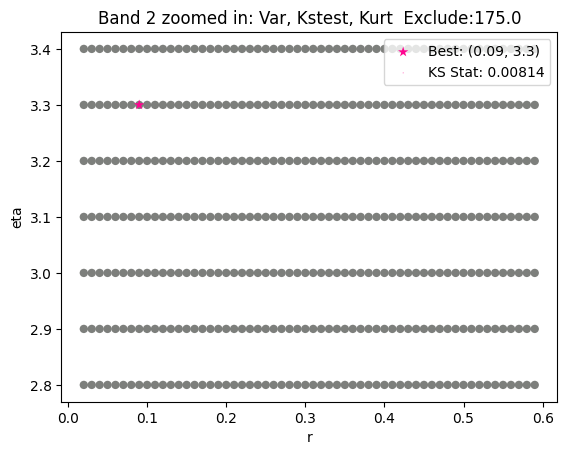

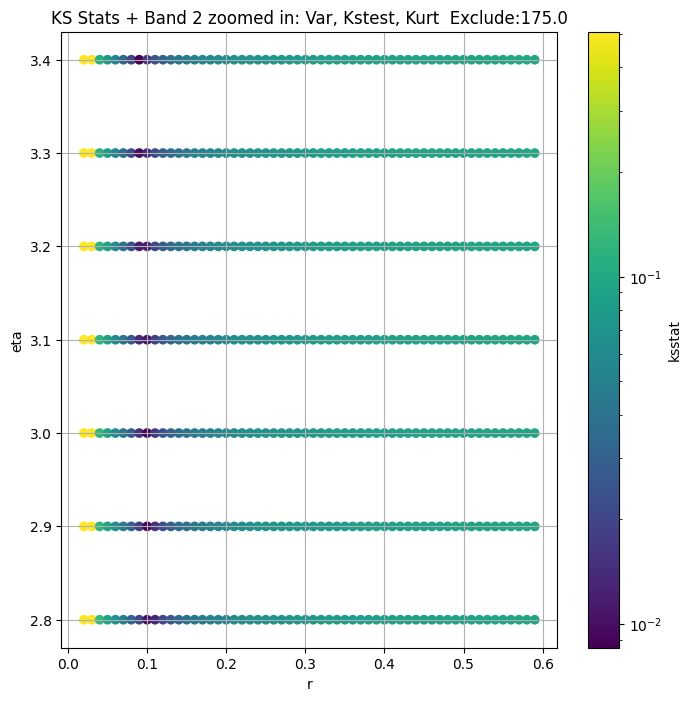

Band 5


100%|██████████| 522/522 [00:03<00:00, 130.67it/s]


Finding Minimum after computing 522 CDFs
band 5, 500.0 + 100 = 600, ksstat: 0.00906619978014822, var: 113.91106414794922


100%|██████████| 522/522 [00:02<00:00, 176.58it/s]


Finding Minimum after computing 522 CDFs
band 5, 500.0 + 75 = 575, ksstat: 0.008680576621063252, var: 115.94280242919922


100%|██████████| 522/522 [00:02<00:00, 178.47it/s]


Finding Minimum after computing 522 CDFs
band 5, 500.0 + 50 = 550, ksstat: 0.00828543118110936, var: 118.10823059082031


100%|██████████| 522/522 [00:02<00:00, 185.03it/s]


Finding Minimum after computing 522 CDFs
band 5, 500.0 + 25 = 525, ksstat: 0.007941354601405215, var: 120.41593933105469


100%|██████████| 522/522 [00:02<00:00, 178.51it/s]


Finding Minimum after computing 522 CDFs
band 5, 500.0 + 0 = 500, ksstat: 0.0075604920229448425, var: 122.88612365722656


100%|██████████| 522/522 [00:02<00:00, 178.95it/s]


Finding Minimum after computing 522 CDFs
band 5, 500.0 + -25 = 475, ksstat: 0.007232258066512065, var: 125.50467681884766


100%|██████████| 522/522 [00:02<00:00, 185.14it/s]


Finding Minimum after computing 522 CDFs
band 5, 500.0 + -50 = 450, ksstat: 0.0069284919026205705, var: 128.31478881835938


100%|██████████| 522/522 [00:02<00:00, 178.38it/s]


Finding Minimum after computing 522 CDFs
band 5, 500.0 + -75 = 425, ksstat: 0.00659583056214863, var: 131.35586547851562


100%|██████████| 522/522 [00:02<00:00, 180.85it/s]


Finding Minimum after computing 522 CDFs
band 5, 500.0 + -100 = 400, ksstat: 0.006689860186938235, var: 134.67356872558594
Number of samples: 100000, Without approximation : 117000.0


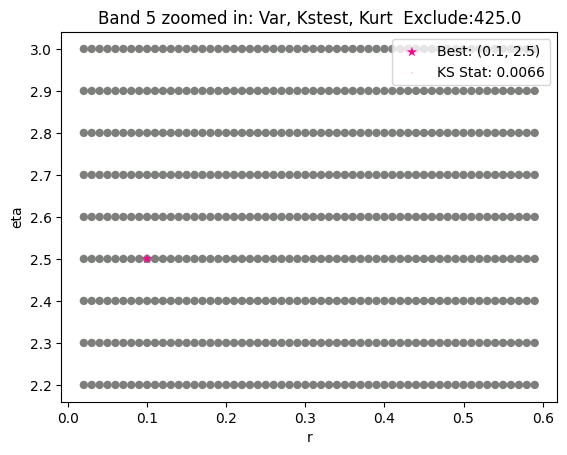

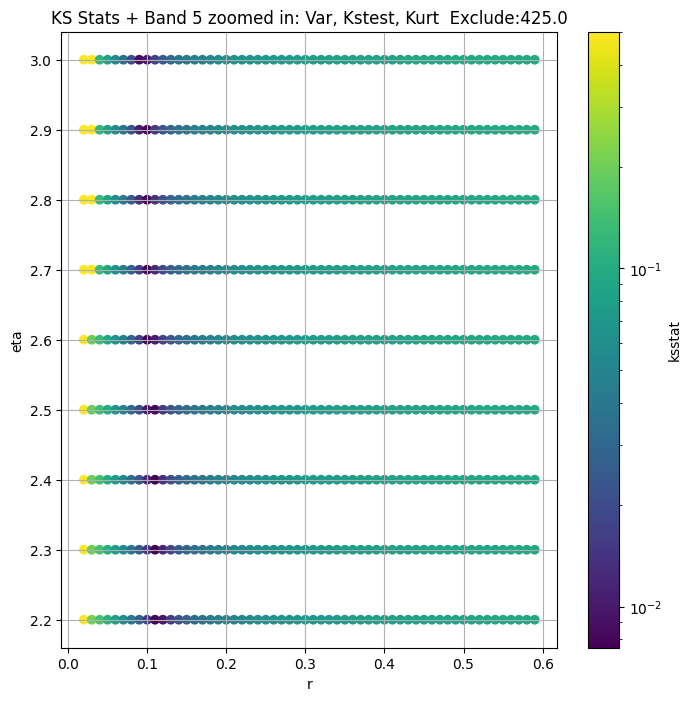

Band 8


100%|██████████| 522/522 [00:02<00:00, 185.25it/s]


Finding Minimum after computing 522 CDFs
band 8, 350.0 + 100 = 450, ksstat: 0.006811776819690696, var: 48.48090744018555


100%|██████████| 522/522 [00:04<00:00, 119.24it/s]


Finding Minimum after computing 522 CDFs
band 8, 350.0 + 75 = 425, ksstat: 0.006536897618508619, var: 49.55091857910156


100%|██████████| 522/522 [00:03<00:00, 156.99it/s]


Finding Minimum after computing 522 CDFs
band 8, 350.0 + 50 = 400, ksstat: 0.006235455374890453, var: 50.71072769165039


100%|██████████| 522/522 [00:03<00:00, 162.08it/s]


Finding Minimum after computing 522 CDFs
band 8, 350.0 + 25 = 375, ksstat: 0.005977262141906303, var: 51.96821975708008


100%|██████████| 522/522 [00:03<00:00, 164.51it/s]


Finding Minimum after computing 522 CDFs
band 8, 350.0 + 0 = 350, ksstat: 0.006476317871871737, var: 53.34210968017578


100%|██████████| 522/522 [00:03<00:00, 165.59it/s]


Finding Minimum after computing 522 CDFs
band 8, 350.0 + -25 = 325, ksstat: 0.006923917679784397, var: 54.84995651245117


100%|██████████| 522/522 [00:03<00:00, 167.81it/s]


Finding Minimum after computing 522 CDFs
band 8, 350.0 + -50 = 300, ksstat: 0.0076870732368295724, var: 56.49187088012695


100%|██████████| 522/522 [00:02<00:00, 175.56it/s]


Finding Minimum after computing 522 CDFs
band 8, 350.0 + -75 = 275, ksstat: 0.008579850269801681, var: 58.291595458984375


100%|██████████| 522/522 [00:03<00:00, 172.20it/s]


Finding Minimum after computing 522 CDFs
band 8, 350.0 + -100 = 250, ksstat: 0.009266466804543017, var: 60.32371520996094
Number of samples: 100000, Without approximation : 189000.0


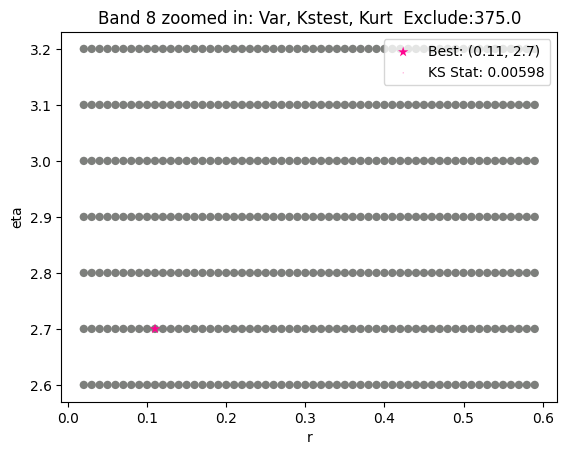

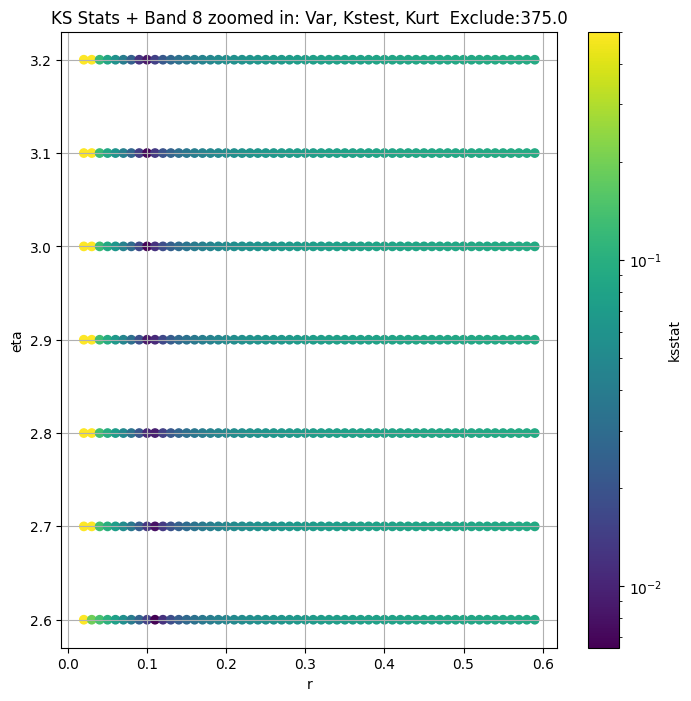

Band 11


100%|██████████| 580/580 [00:03<00:00, 156.45it/s]


Finding Minimum after computing 580 CDFs
band 11, 300.0 + 100 = 400, ksstat: 0.005552973408063155, var: 23.173269271850586


100%|██████████| 580/580 [00:04<00:00, 137.51it/s]


Finding Minimum after computing 580 CDFs
band 11, 300.0 + 75 = 375, ksstat: 0.0052559389914840215, var: 23.646076202392578


100%|██████████| 580/580 [00:04<00:00, 132.28it/s]


Finding Minimum after computing 580 CDFs
band 11, 300.0 + 50 = 350, ksstat: 0.004962653925488003, var: 24.163537979125977


100%|██████████| 580/580 [00:04<00:00, 140.20it/s]


Finding Minimum after computing 580 CDFs
band 11, 300.0 + 25 = 325, ksstat: 0.004694772351897747, var: 24.731645584106445


100%|██████████| 580/580 [00:03<00:00, 181.86it/s]


Finding Minimum after computing 580 CDFs
band 11, 300.0 + 0 = 300, ksstat: 0.004431908724089495, var: 25.356552124023438


100%|██████████| 580/580 [00:03<00:00, 184.66it/s]


Finding Minimum after computing 580 CDFs
band 11, 300.0 + -25 = 275, ksstat: 0.004165988898754414, var: 26.054203033447266


100%|██████████| 580/580 [00:03<00:00, 186.75it/s]


Finding Minimum after computing 580 CDFs
band 11, 300.0 + -50 = 250, ksstat: 0.004632182717604946, var: 26.8430233001709


100%|██████████| 580/580 [00:03<00:00, 185.11it/s]


Finding Minimum after computing 580 CDFs
band 11, 300.0 + -75 = 225, ksstat: 0.005434146078967195, var: 27.73760223388672


100%|██████████| 580/580 [00:03<00:00, 182.97it/s]


Finding Minimum after computing 580 CDFs
band 11, 300.0 + -100 = 200, ksstat: 0.006437672823770724, var: 28.78376579284668
Number of samples: 100000, Without approximation : 495000.0


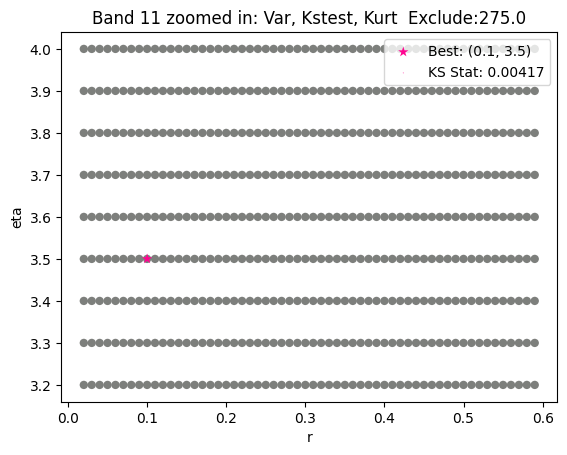

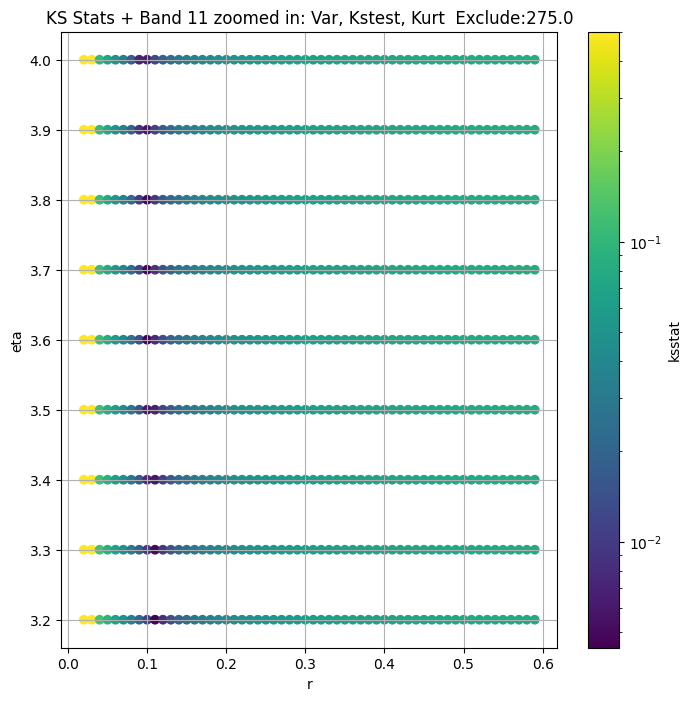

Band 14


100%|██████████| 580/580 [00:03<00:00, 177.70it/s]


Finding Minimum after computing 580 CDFs
band 14, 250.0 + 100 = 350, ksstat: 0.004560964020149383, var: 10.933156967163086


100%|██████████| 580/580 [00:03<00:00, 186.74it/s]


Finding Minimum after computing 580 CDFs
band 14, 250.0 + 75 = 325, ksstat: 0.004251603147815919, var: 11.151646614074707


100%|██████████| 580/580 [00:03<00:00, 185.02it/s]


Finding Minimum after computing 580 CDFs
band 14, 250.0 + 50 = 300, ksstat: 0.003968444776692004, var: 11.392712593078613


100%|██████████| 580/580 [00:03<00:00, 186.51it/s]


Finding Minimum after computing 580 CDFs
band 14, 250.0 + 25 = 275, ksstat: 0.003699159802000862, var: 11.66120433807373


100%|██████████| 580/580 [00:03<00:00, 179.03it/s]


Finding Minimum after computing 580 CDFs
band 14, 250.0 + 0 = 250, ksstat: 0.003455017346165823, var: 11.965662956237793


100%|██████████| 580/580 [00:03<00:00, 186.48it/s]


Finding Minimum after computing 580 CDFs
band 14, 250.0 + -25 = 225, ksstat: 0.003231336423252018, var: 12.312868118286133


100%|██████████| 580/580 [00:03<00:00, 179.09it/s]


Finding Minimum after computing 580 CDFs
band 14, 250.0 + -50 = 200, ksstat: 0.0033816013893118724, var: 12.716778755187988


100%|██████████| 580/580 [00:03<00:00, 183.90it/s]


Finding Minimum after computing 580 CDFs
band 14, 250.0 + -75 = 175, ksstat: 0.004519666295263902, var: 13.19189453125


100%|██████████| 580/580 [00:03<00:00, 186.80it/s]


Finding Minimum after computing 580 CDFs
band 14, 250.0 + -100 = 150, ksstat: 0.00574866449846656, var: 13.764429092407227
Number of samples: 100000, Without approximation : 1134000.0


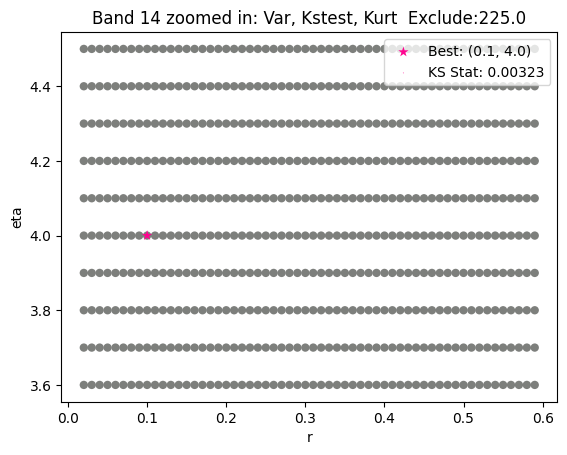

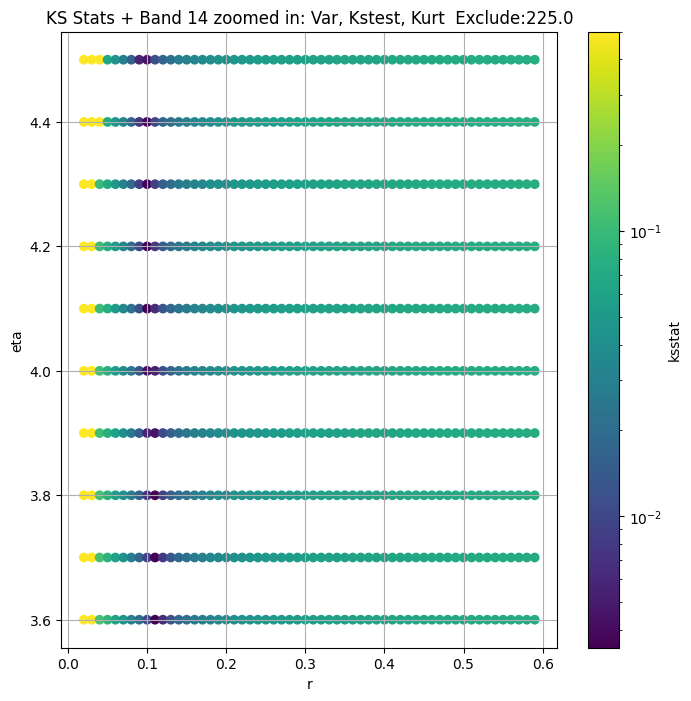

Band 17


100%|██████████| 522/522 [00:03<00:00, 165.63it/s]


Finding Minimum after computing 522 CDFs
band 17, 200.0 + 100 = 300, ksstat: 0.004110046445359445, var: 5.796036243438721


100%|██████████| 522/522 [00:02<00:00, 179.85it/s]


Finding Minimum after computing 522 CDFs
band 17, 200.0 + 75 = 275, ksstat: 0.003669403471944159, var: 5.918033123016357


100%|██████████| 522/522 [00:02<00:00, 182.20it/s]


Finding Minimum after computing 522 CDFs
band 17, 200.0 + 50 = 250, ksstat: 0.0033184769060867142, var: 6.054446697235107


100%|██████████| 522/522 [00:02<00:00, 181.15it/s]


Finding Minimum after computing 522 CDFs
band 17, 200.0 + 25 = 225, ksstat: 0.00301085847233731, var: 6.2095818519592285


100%|██████████| 522/522 [00:02<00:00, 186.35it/s]


Finding Minimum after computing 522 CDFs
band 17, 200.0 + 0 = 200, ksstat: 0.002742007742790239, var: 6.389866828918457


100%|██████████| 522/522 [00:02<00:00, 186.78it/s]


Finding Minimum after computing 522 CDFs
band 17, 200.0 + -25 = 175, ksstat: 0.002565376997466895, var: 6.603076934814453


100%|██████████| 522/522 [00:02<00:00, 185.34it/s]


Finding Minimum after computing 522 CDFs
band 17, 200.0 + -50 = 150, ksstat: 0.0032831511428900173, var: 6.860109806060791


100%|██████████| 522/522 [00:02<00:00, 186.26it/s]


Finding Minimum after computing 522 CDFs
band 17, 200.0 + -75 = 125, ksstat: 0.00468392508077288, var: 7.182057857513428


100%|██████████| 522/522 [00:03<00:00, 136.28it/s]


Finding Minimum after computing 522 CDFs
band 17, 200.0 + -100 = 100, ksstat: 0.005649217689710828, var: 7.5985331535339355
Number of samples: 100000, Without approximation : 2574000.0


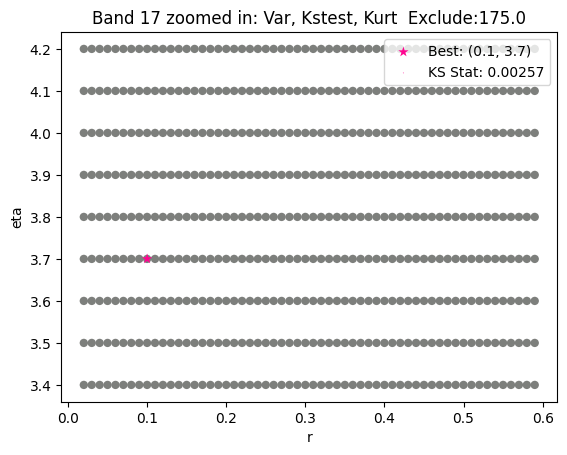

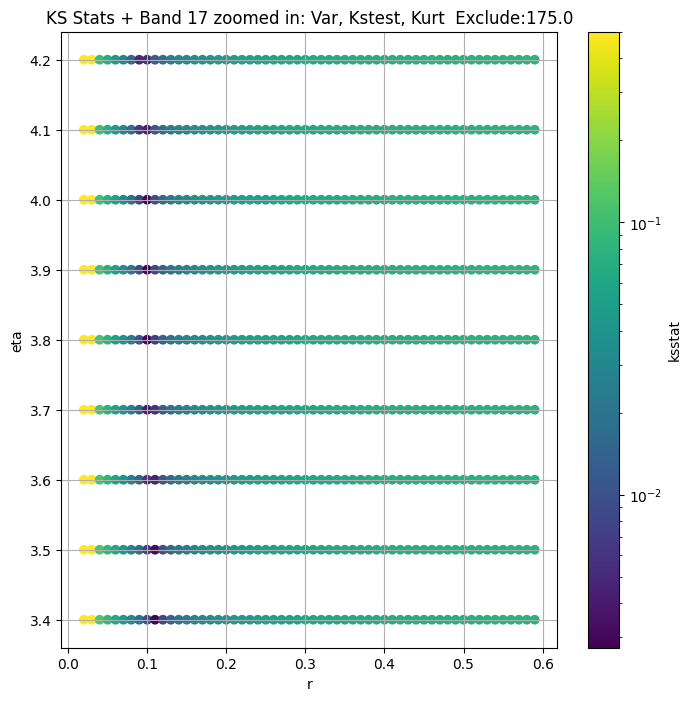

Band 20


100%|██████████| 522/522 [00:03<00:00, 155.46it/s]


Finding Minimum after computing 522 CDFs
band 20, 200.0 + 100 = 300, ksstat: 0.004930014723075318, var: 3.249690055847168


100%|██████████| 522/522 [00:02<00:00, 175.15it/s]


Finding Minimum after computing 522 CDFs
band 20, 200.0 + 75 = 275, ksstat: 0.004400462955985392, var: 3.323763132095337


100%|██████████| 522/522 [00:03<00:00, 169.71it/s]


Finding Minimum after computing 522 CDFs
band 20, 200.0 + 50 = 250, ksstat: 0.003928876497147654, var: 3.4067933559417725


100%|██████████| 522/522 [00:03<00:00, 173.44it/s]


Finding Minimum after computing 522 CDFs
band 20, 200.0 + 25 = 225, ksstat: 0.0034450313078171185, var: 3.5012829303741455


100%|██████████| 522/522 [00:02<00:00, 174.15it/s]


Finding Minimum after computing 522 CDFs
band 20, 200.0 + 0 = 200, ksstat: 0.00344366670656715, var: 3.6107542514801025


100%|██████████| 522/522 [00:03<00:00, 159.07it/s]


Finding Minimum after computing 522 CDFs
band 20, 200.0 + -25 = 175, ksstat: 0.004478434079922877, var: 3.7397663593292236


100%|██████████| 522/522 [00:02<00:00, 179.05it/s]


Finding Minimum after computing 522 CDFs
band 20, 200.0 + -50 = 150, ksstat: 0.004935498370980174, var: 3.8958184719085693


100%|██████████| 522/522 [00:02<00:00, 175.86it/s]


Finding Minimum after computing 522 CDFs
band 20, 200.0 + -75 = 125, ksstat: 0.005879709782161124, var: 4.089313507080078


100%|██████████| 522/522 [00:02<00:00, 175.52it/s]


Finding Minimum after computing 522 CDFs
band 20, 200.0 + -100 = 100, ksstat: 0.0068236975457612314, var: 4.3391337394714355
Number of samples: 100000, Without approximation : 5967000.0


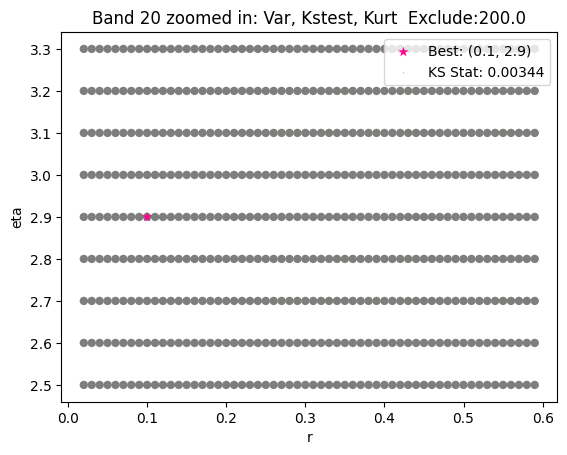

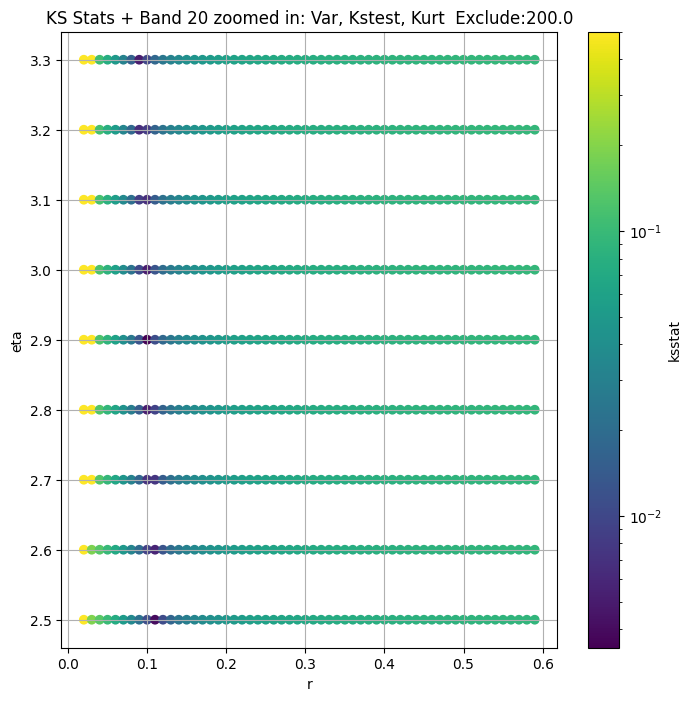

Band 23


100%|██████████| 522/522 [00:03<00:00, 152.56it/s]


Finding Minimum after computing 522 CDFs
band 23, 250.0 + 100 = 350, ksstat: 0.006665264591124043, var: 1.2815145254135132


100%|██████████| 522/522 [00:02<00:00, 179.24it/s]


Finding Minimum after computing 522 CDFs
band 23, 250.0 + 75 = 325, ksstat: 0.006228596730160407, var: 1.306281328201294


100%|██████████| 522/522 [00:02<00:00, 174.49it/s]


Finding Minimum after computing 522 CDFs
band 23, 250.0 + 50 = 300, ksstat: 0.005854662014505796, var: 1.3331773281097412


100%|██████████| 522/522 [00:02<00:00, 184.10it/s]


Finding Minimum after computing 522 CDFs
band 23, 250.0 + 25 = 275, ksstat: 0.0053900354817950635, var: 1.36264169216156


100%|██████████| 522/522 [00:02<00:00, 177.94it/s]


Finding Minimum after computing 522 CDFs
band 23, 250.0 + 0 = 250, ksstat: 0.004892736800230724, var: 1.3953336477279663


100%|██████████| 522/522 [00:02<00:00, 176.03it/s]


Finding Minimum after computing 522 CDFs
band 23, 250.0 + -25 = 225, ksstat: 0.00451033443039961, var: 1.4320528507232666


100%|██████████| 522/522 [00:03<00:00, 165.52it/s]


Finding Minimum after computing 522 CDFs
band 23, 250.0 + -50 = 200, ksstat: 0.005137559128805758, var: 1.4739996194839478


100%|██████████| 522/522 [00:02<00:00, 177.80it/s]


Finding Minimum after computing 522 CDFs
band 23, 250.0 + -75 = 175, ksstat: 0.005776237124857808, var: 1.5230501890182495


100%|██████████| 522/522 [00:03<00:00, 167.38it/s]


Finding Minimum after computing 522 CDFs
band 23, 250.0 + -100 = 150, ksstat: 0.006435702273924426, var: 1.58195960521698
Number of samples: 100000, Without approximation : 13887000.0


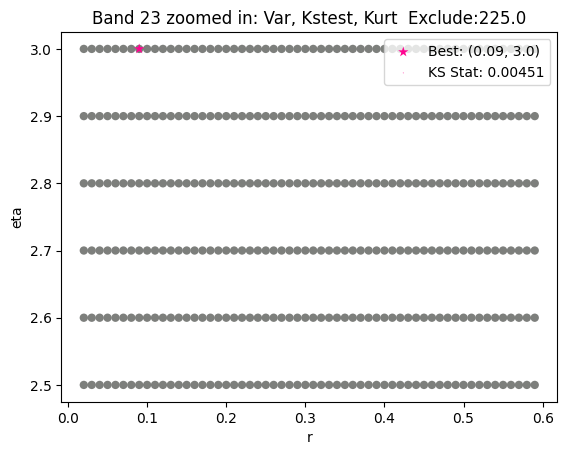

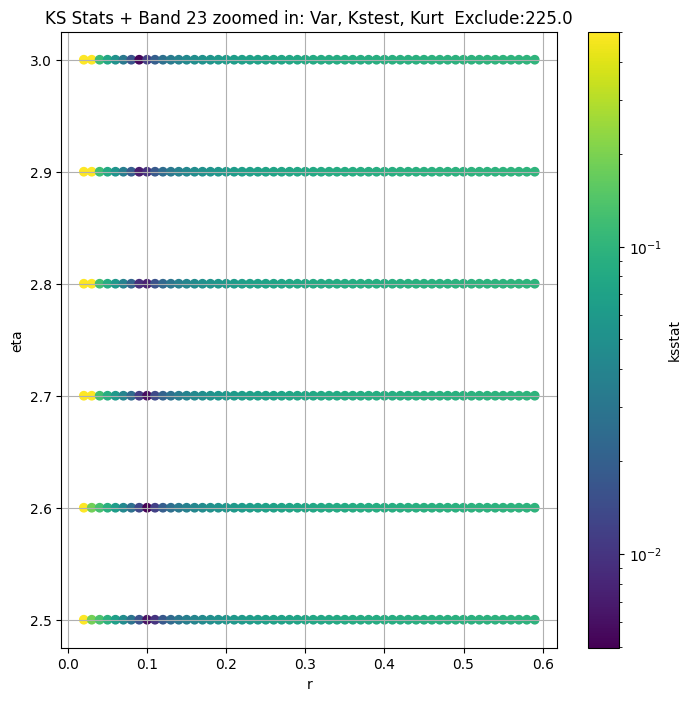

Band 26


100%|██████████| 580/580 [00:03<00:00, 168.10it/s]


Finding Minimum after computing 580 CDFs
band 26, 250.0 + 100 = 350, ksstat: 0.007175686855415142, var: 0.3511570394039154


100%|██████████| 580/580 [00:03<00:00, 149.96it/s]


Finding Minimum after computing 580 CDFs
band 26, 250.0 + 75 = 325, ksstat: 0.0067753387489213335, var: 0.35879167914390564


100%|██████████| 580/580 [00:03<00:00, 174.76it/s]


Finding Minimum after computing 580 CDFs
band 26, 250.0 + 50 = 300, ksstat: 0.00624244571718513, var: 0.3670925199985504


100%|██████████| 580/580 [00:03<00:00, 184.32it/s]


Finding Minimum after computing 580 CDFs
band 26, 250.0 + 25 = 275, ksstat: 0.005860926090586194, var: 0.3762000501155853


100%|██████████| 580/580 [00:03<00:00, 175.89it/s]


Finding Minimum after computing 580 CDFs
band 26, 250.0 + 0 = 250, ksstat: 0.0053842833549148095, var: 0.3863021433353424


100%|██████████| 580/580 [00:03<00:00, 183.33it/s]


Finding Minimum after computing 580 CDFs
band 26, 250.0 + -25 = 225, ksstat: 0.005107147548504276, var: 0.39765578508377075


100%|██████████| 580/580 [00:03<00:00, 165.37it/s]


Finding Minimum after computing 580 CDFs
band 26, 250.0 + -50 = 200, ksstat: 0.005948530229098248, var: 0.41060107946395874


100%|██████████| 580/580 [00:03<00:00, 175.29it/s]


Finding Minimum after computing 580 CDFs
band 26, 250.0 + -75 = 175, ksstat: 0.006014325550426691, var: 0.42566314339637756


100%|██████████| 580/580 [00:03<00:00, 172.99it/s]


Finding Minimum after computing 580 CDFs
band 26, 250.0 + -100 = 150, ksstat: 0.0061283567148276985, var: 0.44363731145858765
Number of samples: 100000, Without approximation : 31968000.0


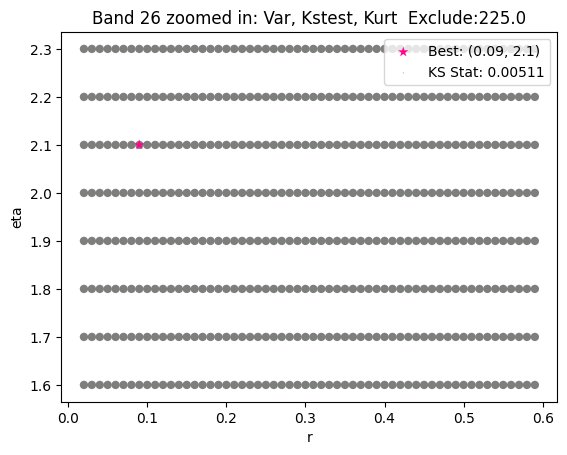

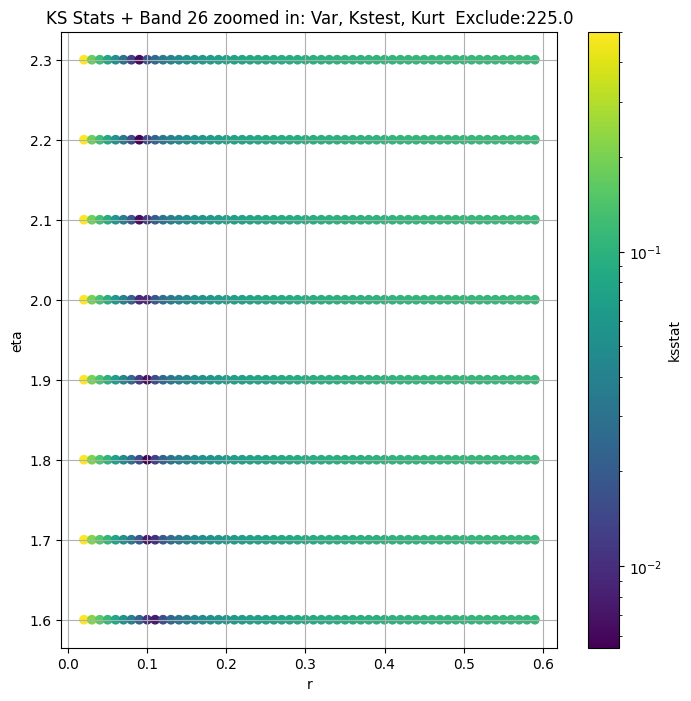

Band 29


100%|██████████| 522/522 [00:02<00:00, 174.44it/s]


Finding Minimum after computing 522 CDFs
band 29, 300.0 + 100 = 400, ksstat: 0.009842964951757849, var: 0.03936196491122246


100%|██████████| 522/522 [00:03<00:00, 161.96it/s]


Finding Minimum after computing 522 CDFs
band 29, 300.0 + 75 = 375, ksstat: 0.00952449194228533, var: 0.04019705206155777


100%|██████████| 522/522 [00:03<00:00, 170.86it/s]


Finding Minimum after computing 522 CDFs
band 29, 300.0 + 50 = 350, ksstat: 0.008968285669694098, var: 0.041092026978731155


100%|██████████| 522/522 [00:03<00:00, 159.15it/s]


Finding Minimum after computing 522 CDFs
band 29, 300.0 + 25 = 325, ksstat: 0.00897774176550914, var: 0.04205668345093727


100%|██████████| 522/522 [00:03<00:00, 168.66it/s]


Finding Minimum after computing 522 CDFs
band 29, 300.0 + 0 = 300, ksstat: 0.008405450108263546, var: 0.04310325160622597


100%|██████████| 522/522 [00:02<00:00, 174.76it/s]


Finding Minimum after computing 522 CDFs
band 29, 300.0 + -25 = 275, ksstat: 0.008869574882194309, var: 0.044247809797525406


100%|██████████| 522/522 [00:02<00:00, 174.96it/s]


Finding Minimum after computing 522 CDFs
band 29, 300.0 + -50 = 250, ksstat: 0.009156504306437496, var: 0.04551412910223007


100%|██████████| 522/522 [00:03<00:00, 162.82it/s]


Finding Minimum after computing 522 CDFs
band 29, 300.0 + -75 = 225, ksstat: 0.009686826007426874, var: 0.046932753175497055


100%|██████████| 522/522 [00:03<00:00, 162.49it/s]


Finding Minimum after computing 522 CDFs
band 29, 300.0 + -100 = 200, ksstat: 0.009877082338024923, var: 0.04854748398065567
Number of samples: 100000, Without approximation : 73701000.0


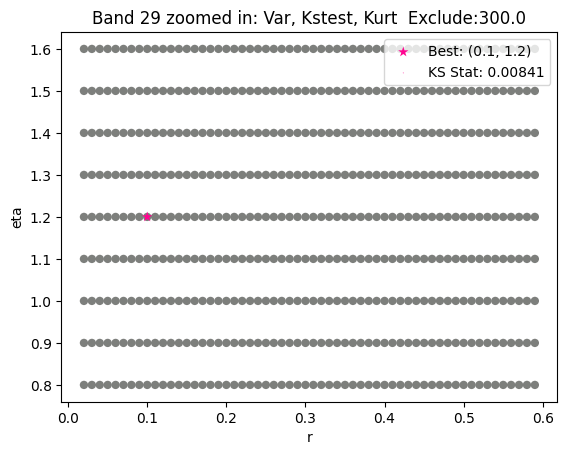

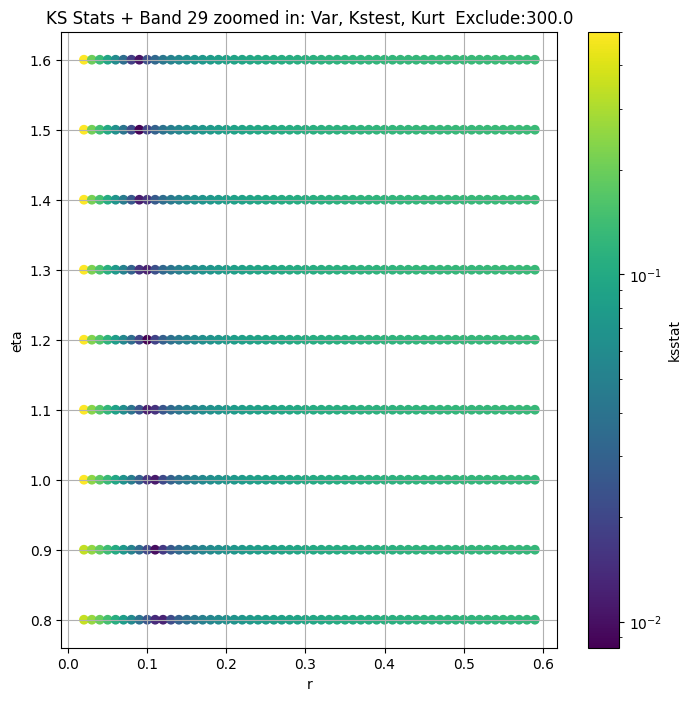

Band 32


100%|██████████| 522/522 [00:02<00:00, 180.74it/s]


Finding Minimum after computing 522 CDFs
band 32, 500.0 + 100 = 600, ksstat: 0.011611388463519098, var: 0.0035648460034281015


100%|██████████| 522/522 [00:03<00:00, 155.01it/s]


Finding Minimum after computing 522 CDFs
band 32, 500.0 + 75 = 575, ksstat: 0.011413684966848785, var: 0.0036221593618392944


100%|██████████| 522/522 [00:03<00:00, 173.13it/s]


Finding Minimum after computing 522 CDFs
band 32, 500.0 + 50 = 550, ksstat: 0.011044013641710499, var: 0.003681891830638051


100%|██████████| 522/522 [00:03<00:00, 172.17it/s]


Finding Minimum after computing 522 CDFs
band 32, 500.0 + 25 = 525, ksstat: 0.010793088252283471, var: 0.00374425295740366


100%|██████████| 522/522 [00:02<00:00, 175.86it/s]


Finding Minimum after computing 522 CDFs
band 32, 500.0 + 0 = 500, ksstat: 0.010542147272644797, var: 0.0038094958290457726


100%|██████████| 522/522 [00:03<00:00, 158.24it/s]


Finding Minimum after computing 522 CDFs
band 32, 500.0 + -25 = 475, ksstat: 0.010494572392454105, var: 0.0038779033347964287


100%|██████████| 522/522 [00:03<00:00, 159.72it/s]


Finding Minimum after computing 522 CDFs
band 32, 500.0 + -50 = 450, ksstat: 0.01108316466347986, var: 0.003949836827814579


100%|██████████| 522/522 [00:03<00:00, 160.29it/s]


Finding Minimum after computing 522 CDFs
band 32, 500.0 + -75 = 425, ksstat: 0.011188264025180139, var: 0.004025694448500872


100%|██████████| 522/522 [00:02<00:00, 175.36it/s]


Finding Minimum after computing 522 CDFs
band 32, 500.0 + -100 = 400, ksstat: 0.011647298766613301, var: 0.0041059209033846855
Number of samples: 100000, Without approximation : 59634000.0


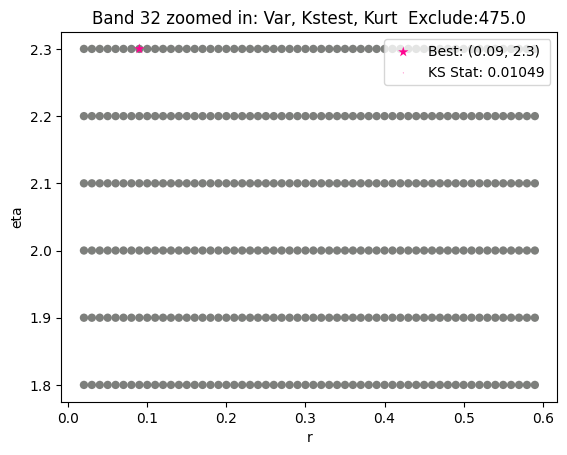

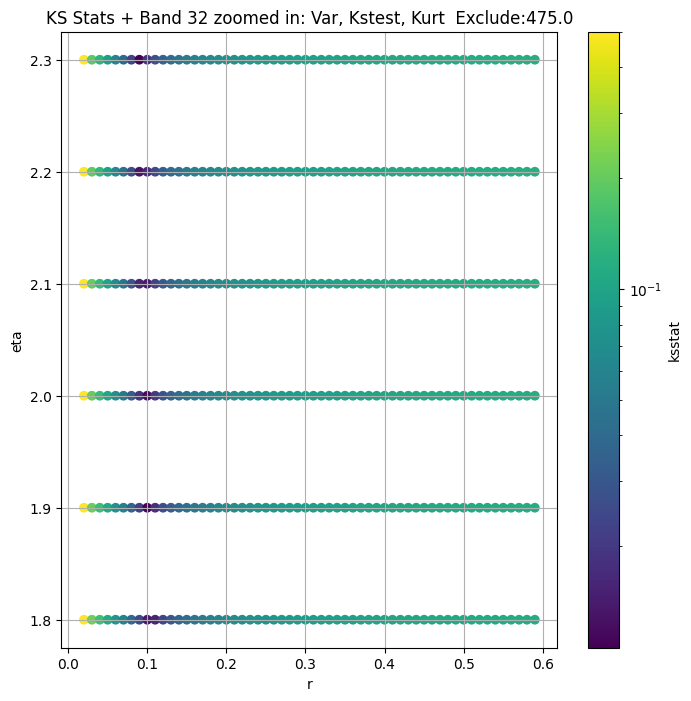

obs_var   var_lower    var_upper     obs_kurt  kurt_lower  \
band                                                                 
2     986.118300  606.263600  1555.946500    356.08157   99.133300   
5     583.566700  329.252300  1187.514300    813.59064  103.779990   
8     195.376500  114.556244   365.574200    612.80610   92.325806   
11    117.897670   48.120650   487.721070   5769.23900   83.057900   
14     40.271010   20.443539   131.923110   2610.08280   75.710780   
17     24.611858    9.834547   129.458800  11181.92200   65.416466   
20     13.320553    5.668727    65.310080   6724.62650   70.291565   
23      6.579030    2.254869    43.818960  16738.59000   63.702858   
26      3.989165    0.647688    40.324917  32596.10400   71.612460   
29      0.426806    0.081010     3.450923  26453.19300   91.602455   
32      0.015853    0.008302     0.044247   1816.90760   91.580090   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2       600.4443        45000.0             0.008542        0.1          3.0   
5      2060.5480       117000.0             0.007594        0.1          2.6   
8      1727.8018       189000.0             0.006685        0.1          3.0   
11     6259.8403       495000.0             0.004432        0.1          3.6   
14     4860.0464      1134000.0             0.003455        0.1          4.1   
17     7685.5044      2574000.0             0.002742        0.1          3.8   
20     6708.6846      5967000.0             0.003444        0.1          2.9   
23     8285.5580     13887000.0             0.004956        0.1          2.6   
26     9318.7330     31968000.0             0.005504        0.1          1.8   
29     9072.5770     73701000.0             0.008405        0.1          1.2   
32     3932.4010     59634000.0             0.010701        0.1          1.9   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      2.897966e-15                   200.0          263.498199   
5      3.296652e-15                   500.0          131.355865   
8      6.142590e-16                   350.0           51.968220   
11     9.268090e-17                   300.0           26.054203   
14     1.841990e-17                   250.0           12.312868   
17     1.637736e-17                   200.0            6.603077   
20     5.102939e-17                   200.0            3.610754   
23     3.743245e-17                   250.0            1.432053   
26     7.234702e-17                   250.0            0.397656   
29     4.672980e-17                   300.0            0.043103   
32     5.475282e-19                   500.0            0.003878   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.006398          0.008138    0.09       3.3   
5                    0.003969          0.006596    0.10       2.5   
8                    0.003123          0.005977    0.11       2.7   
11                   0.001930          0.004166    0.10       3.5   
14                   0.001275          0.003231    0.10       4.0   
17                   0.000846          0.002565    0.10       3.7   
20                   0.000556          0.003444    0.10       2.9   
23                   0.000364          0.004510    0.09       3.0   
26                   0.000240          0.005107    0.09       2.1   
29                   0.000158          0.008405    0.10       1.2   
32                   0.000176          0.010495    0.09       2.3   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2     6.340561e-18                175.0        28476  
5     4.404835e-15                425.0        43875  
8     8.814083e-14                375.0        53155  
11    1.1427

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

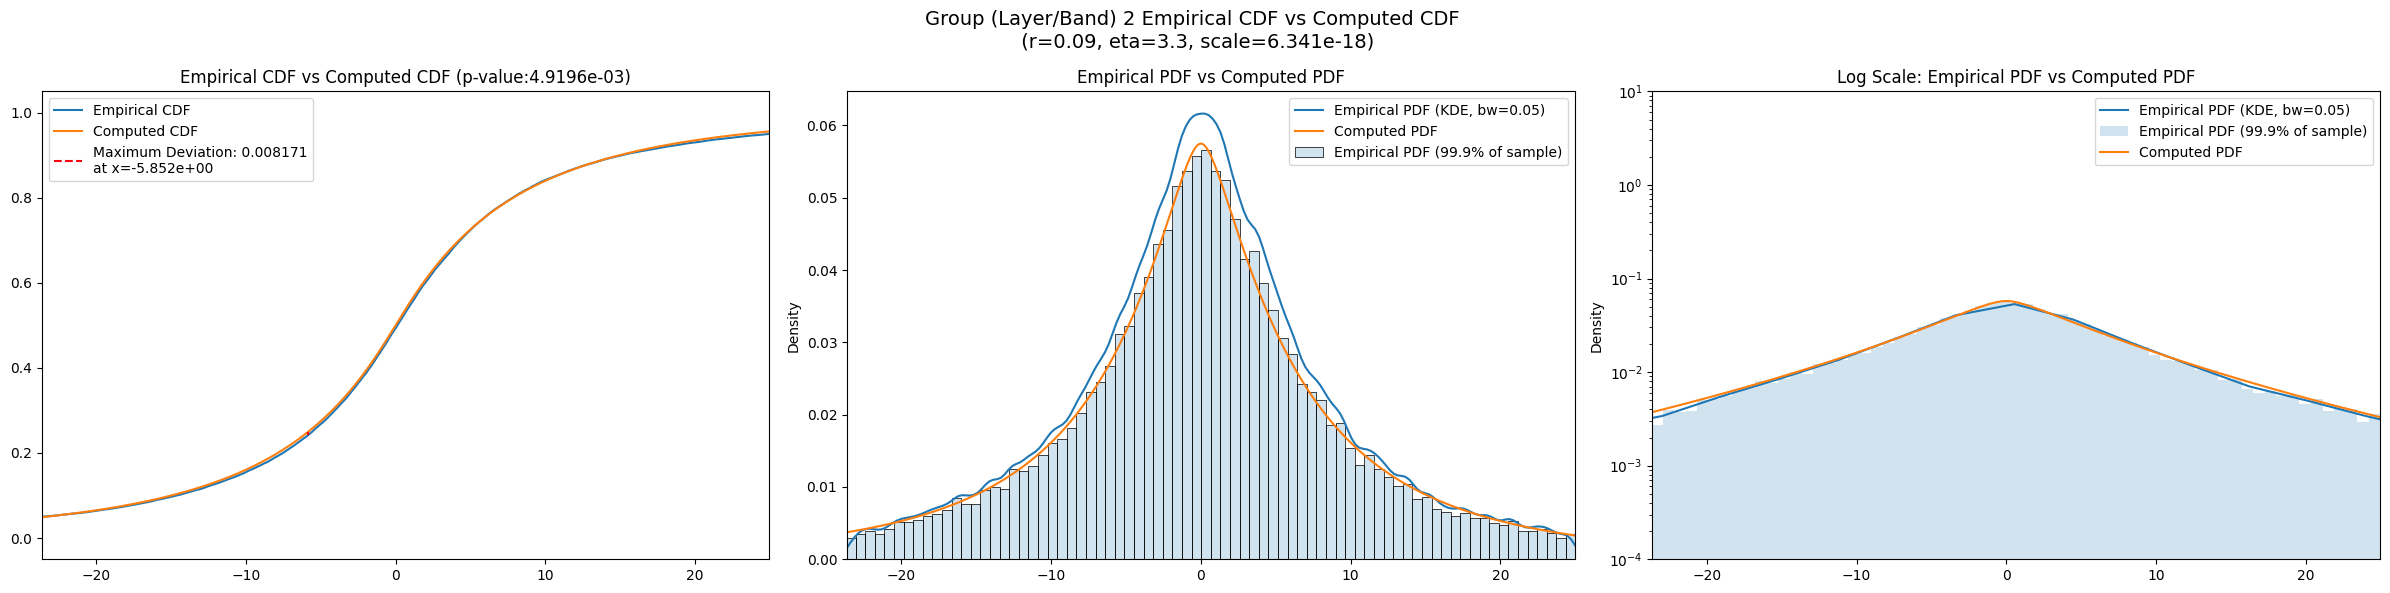

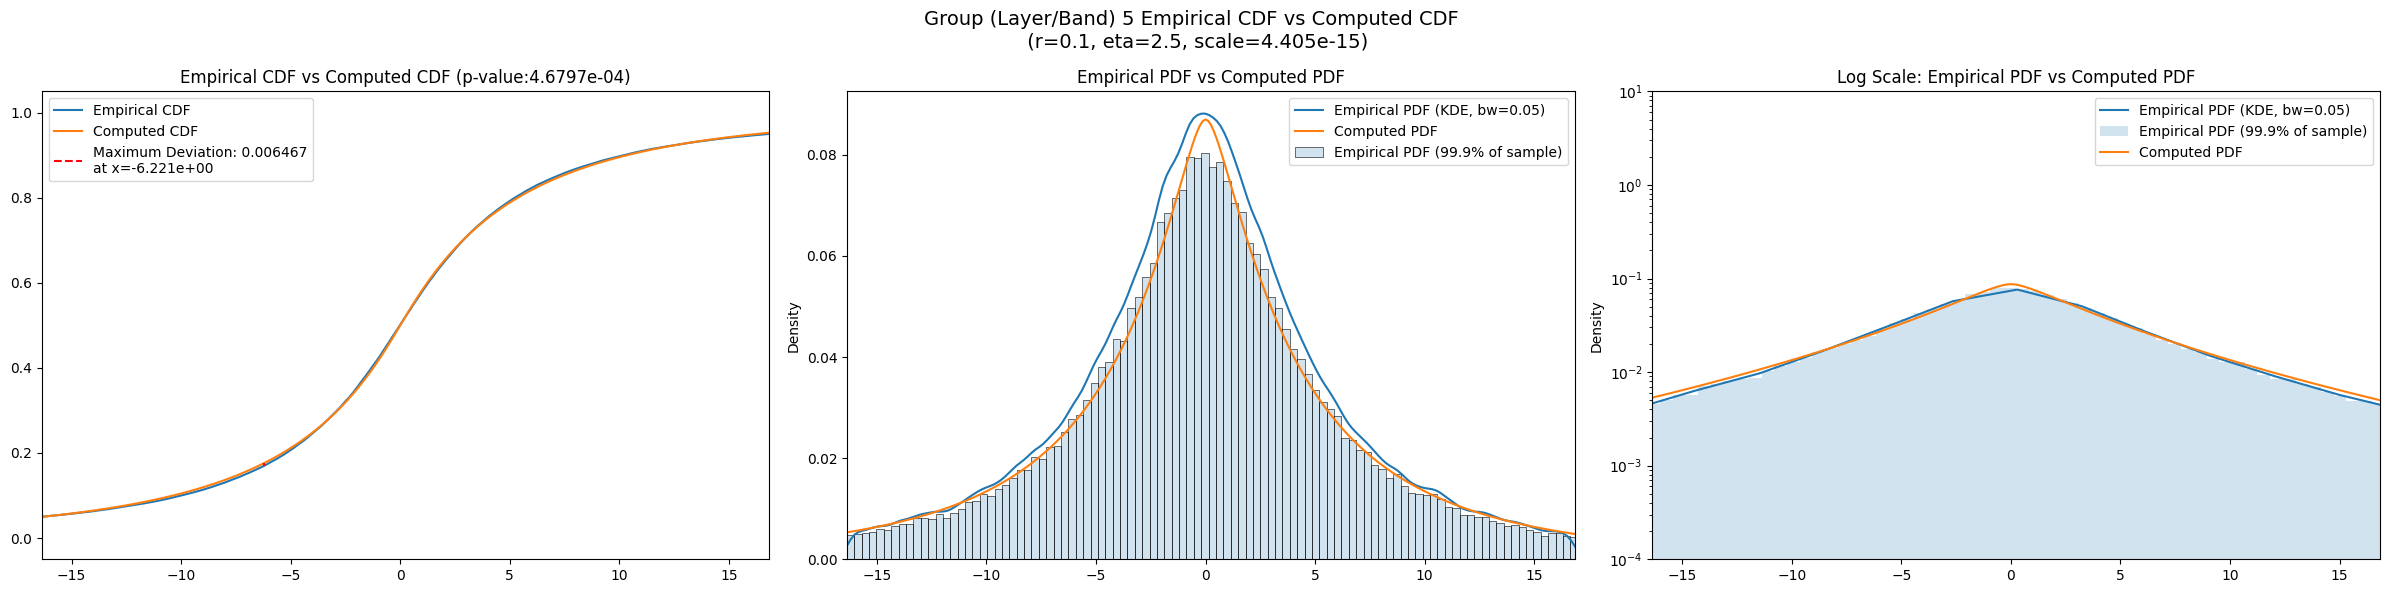

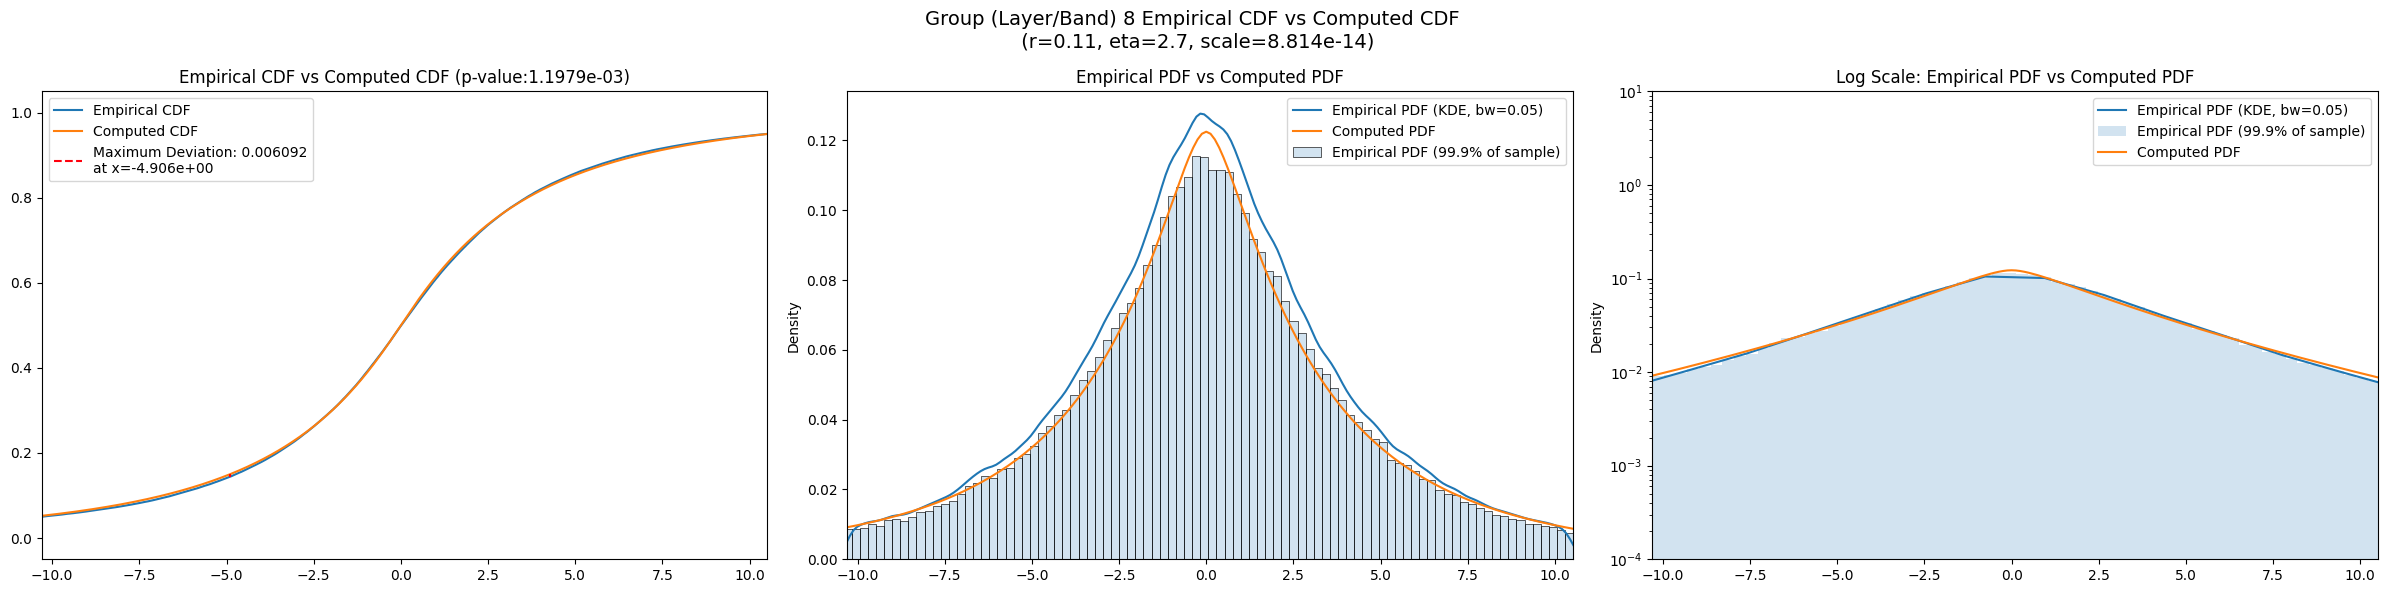

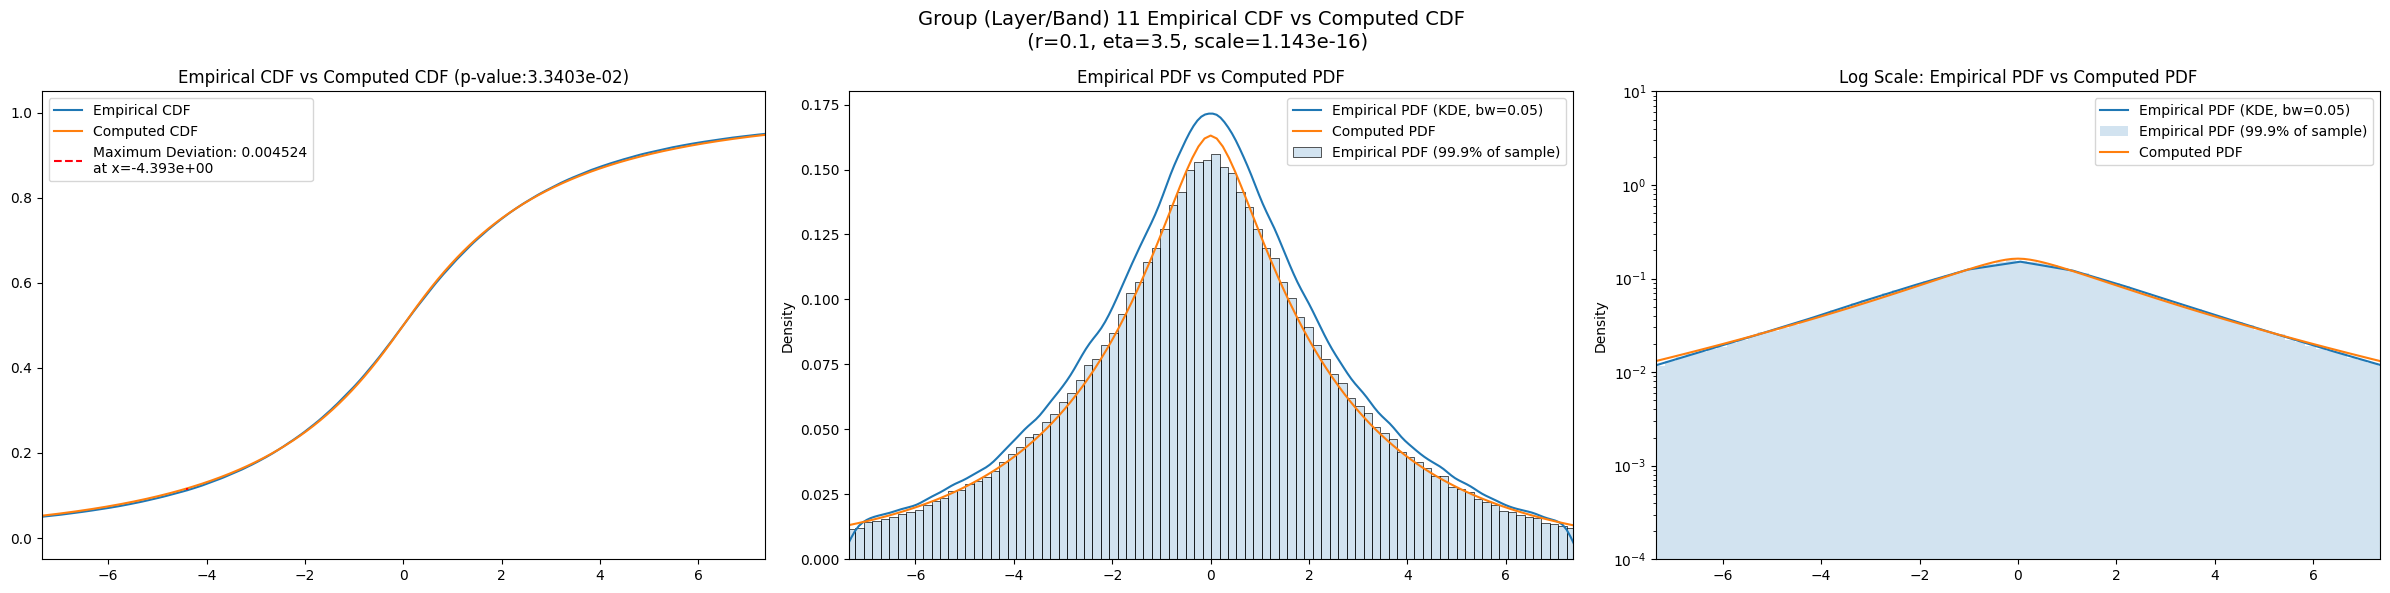

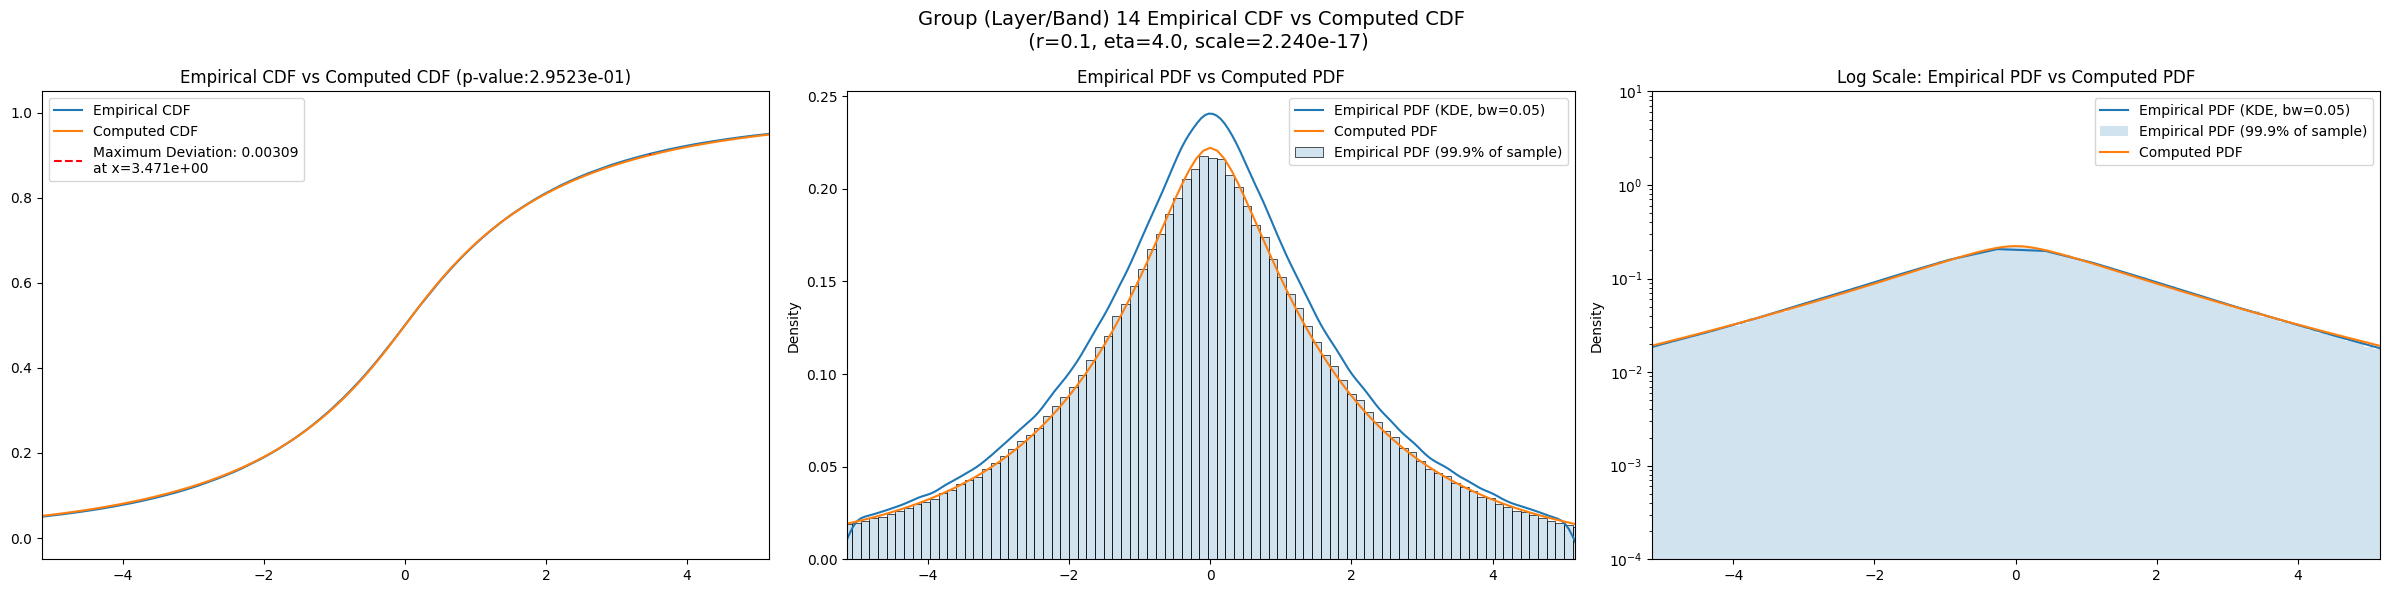

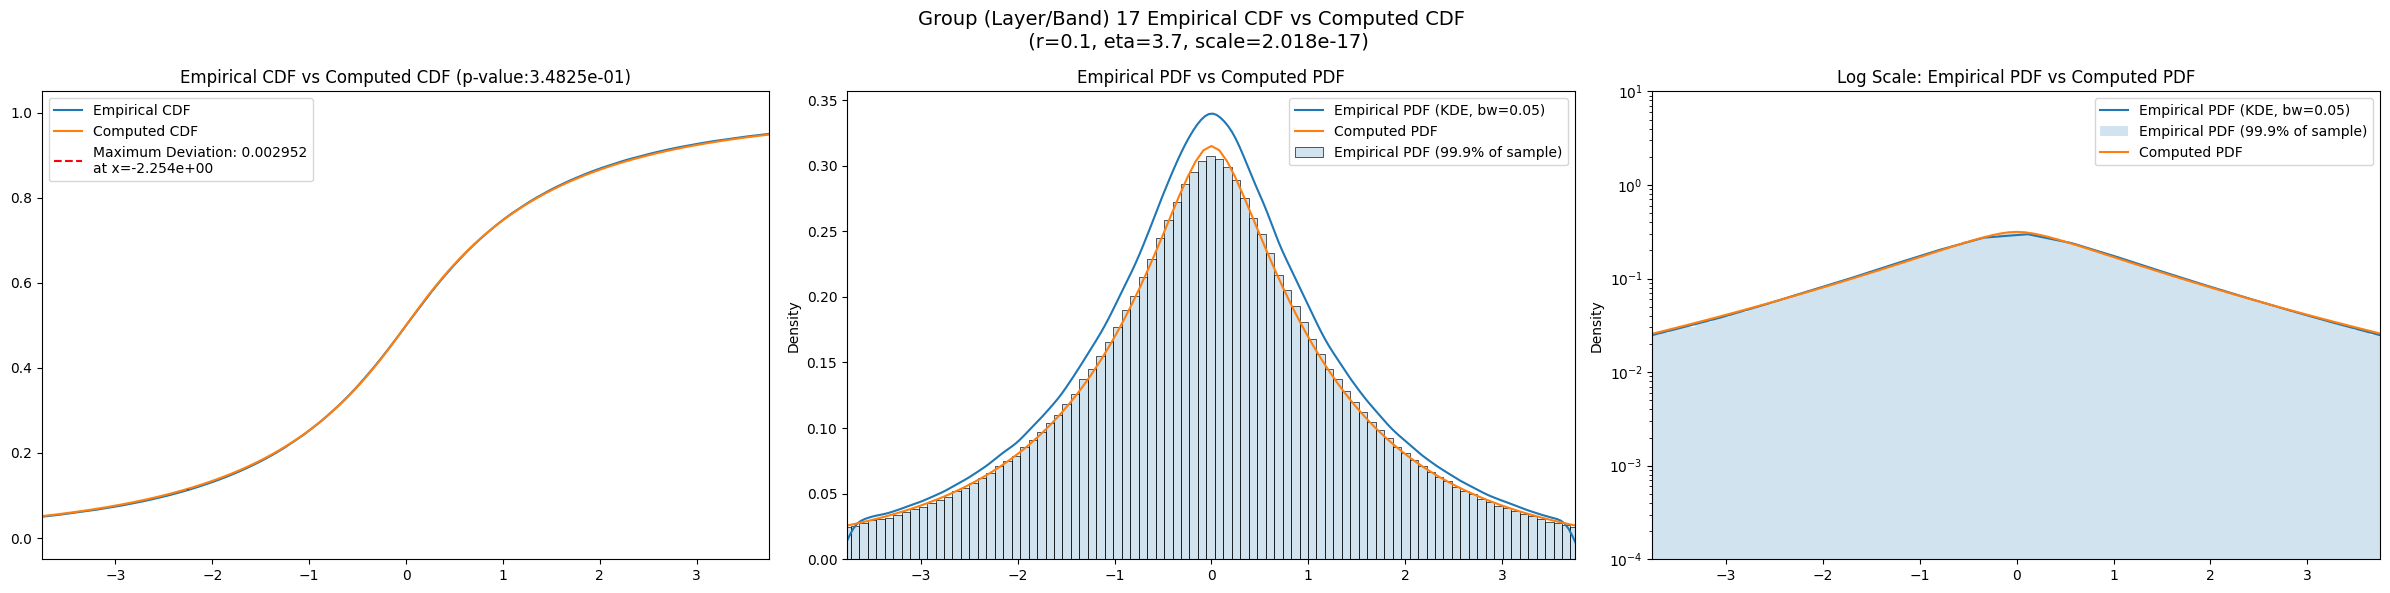

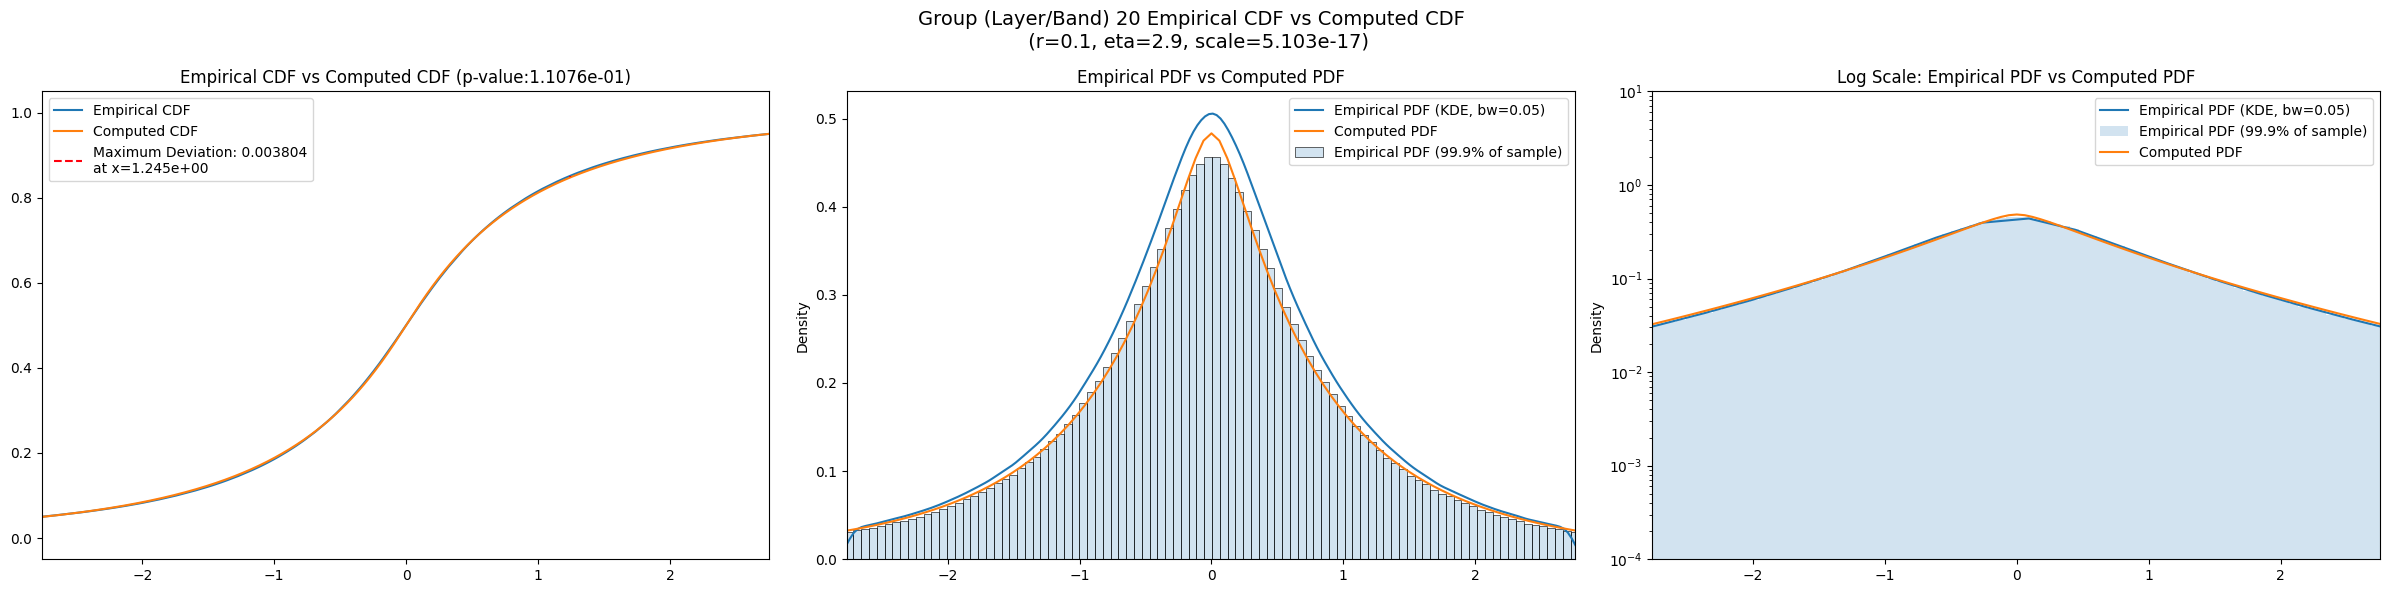

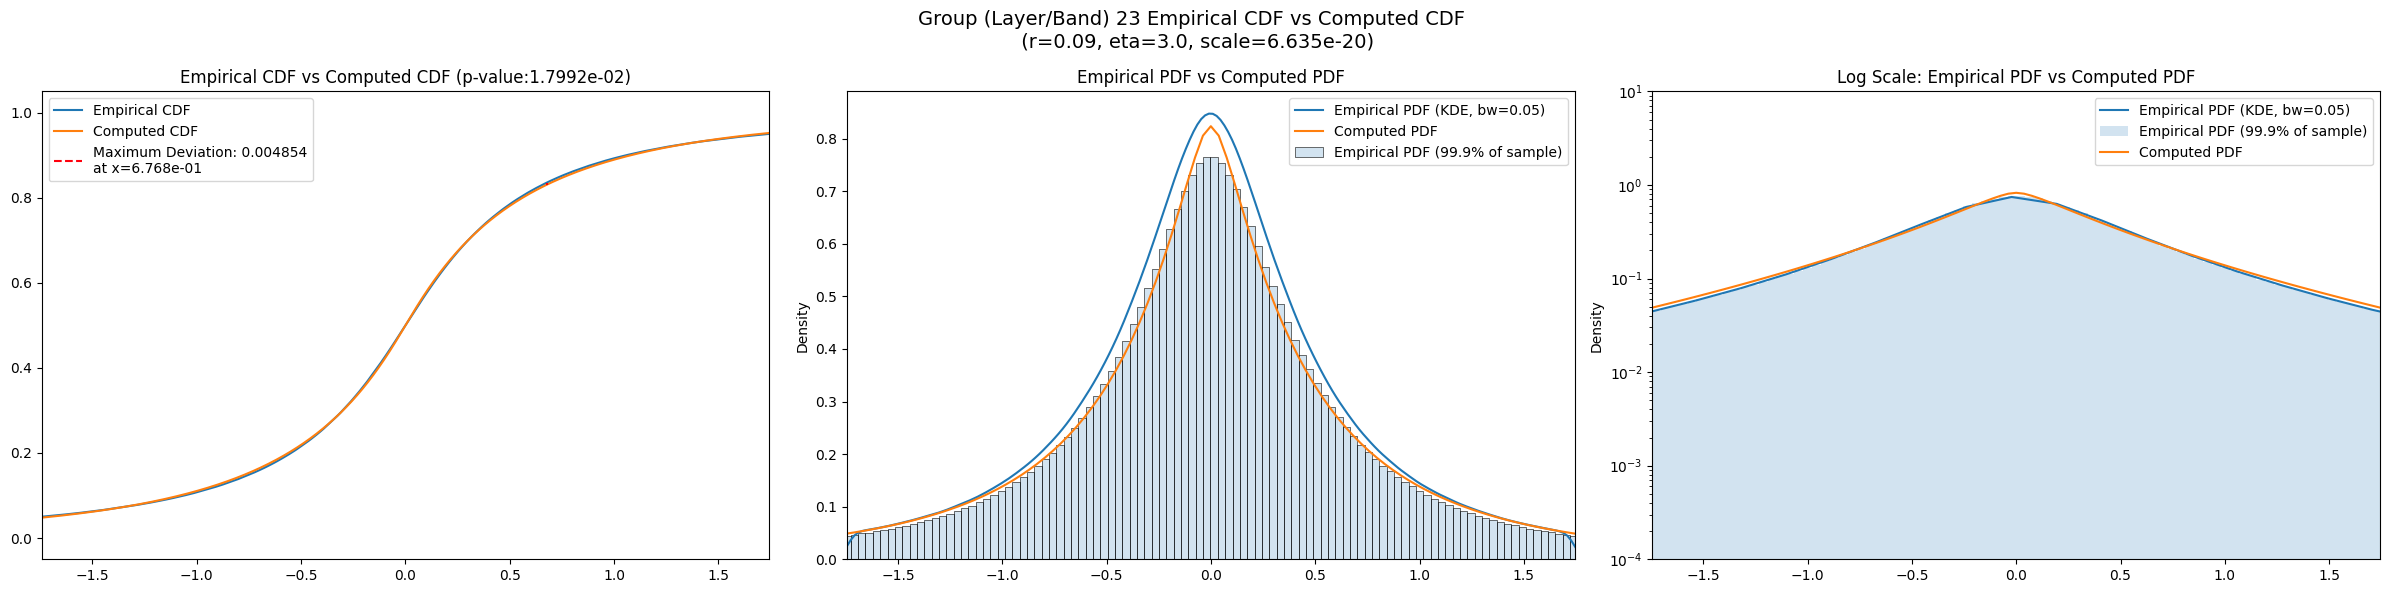

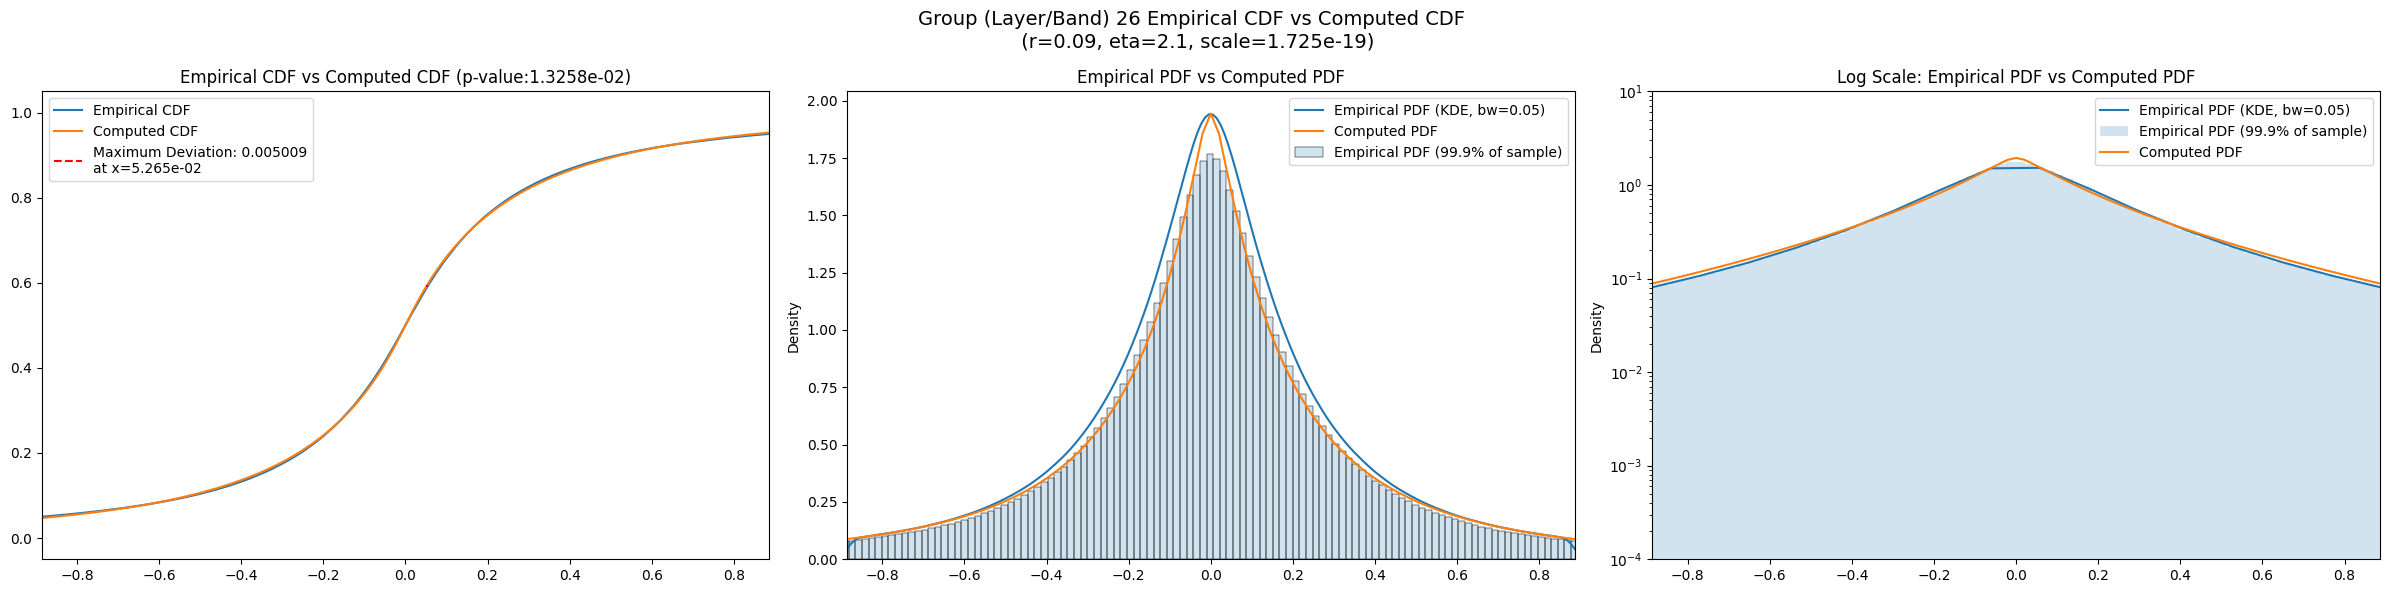

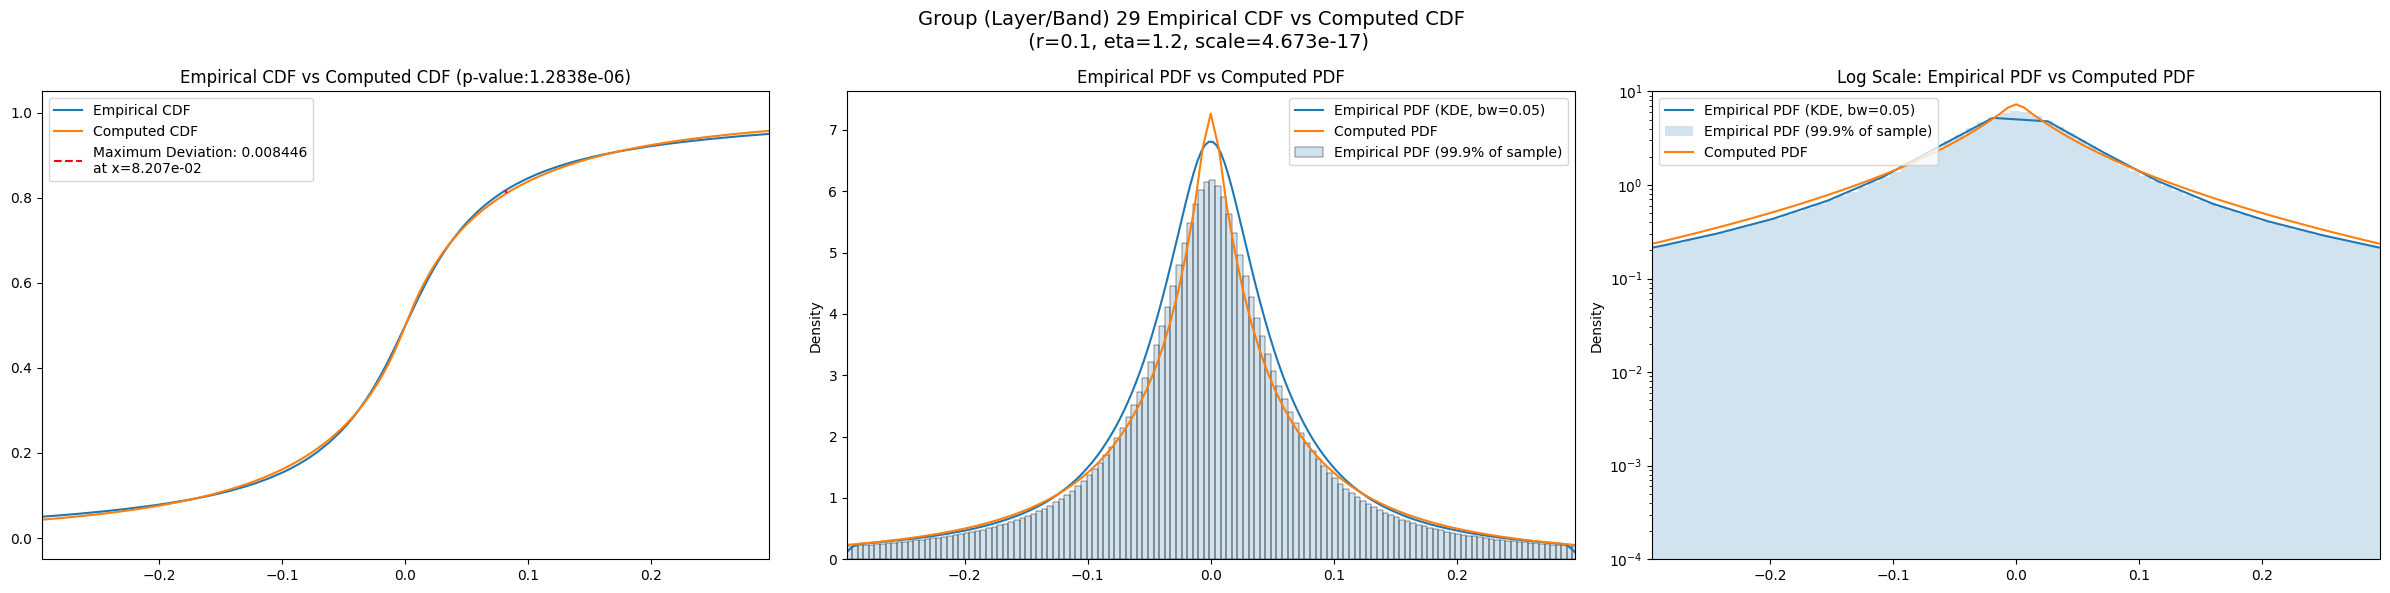

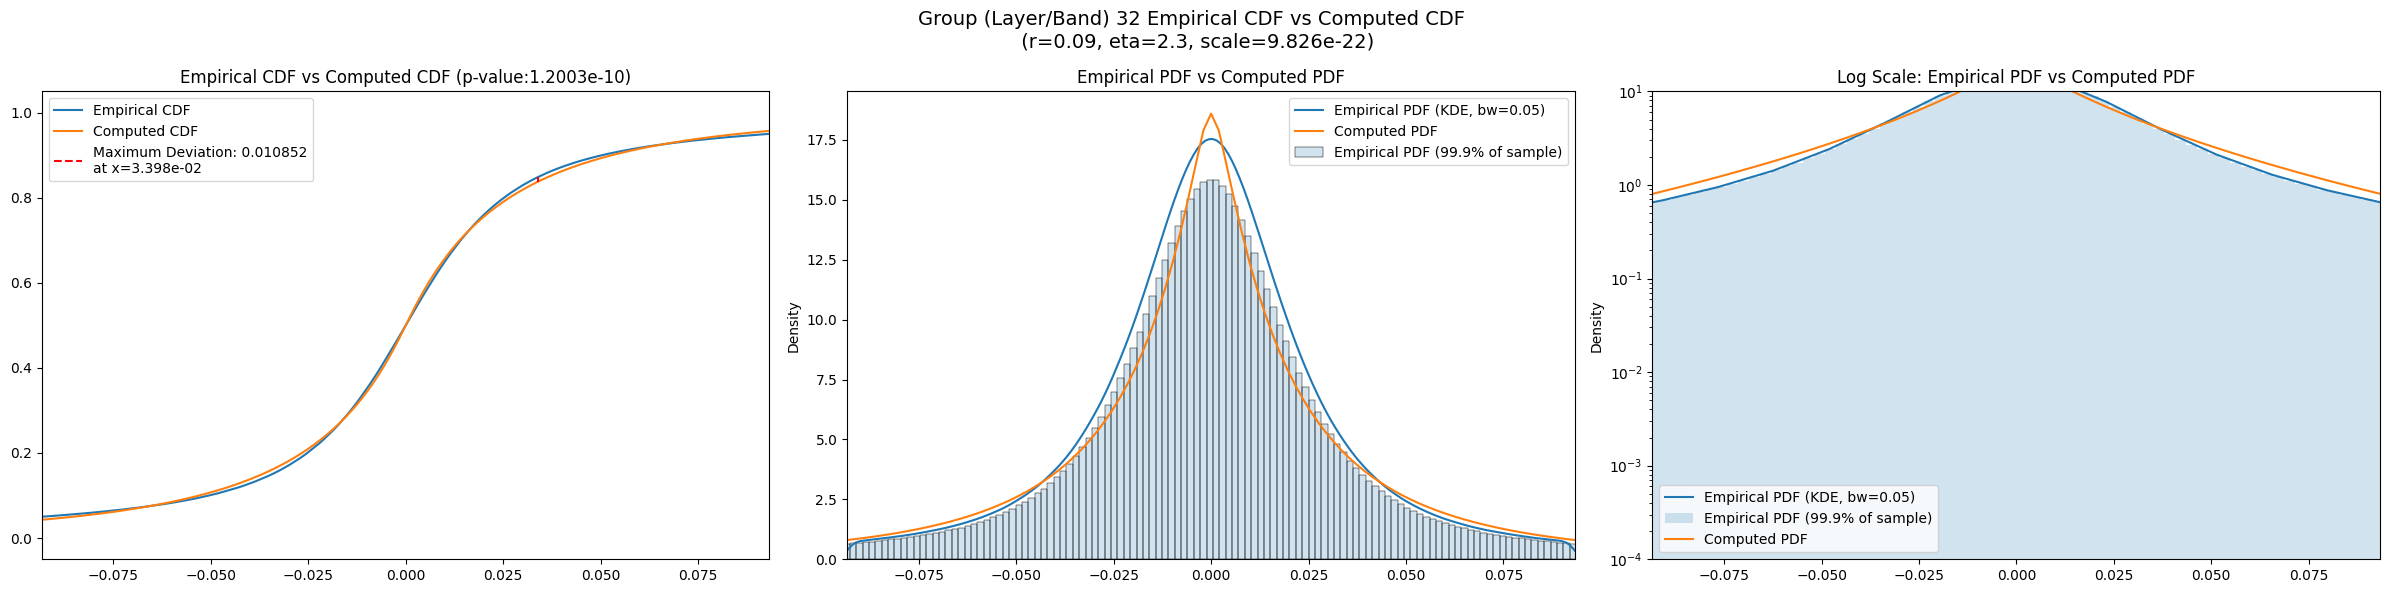

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var   var_lower    var_upper     obs_kurt  kurt_lower  \
band                                                                 
2     986.118300  606.263600  1555.946500    356.08157   99.133300   
5     583.566700  329.252300  1187.514300    813.59064  103.779990   
8     195.376500  114.556244   365.574200    612.80610   92.325806   
11    117.897670   48.120650   487.721070   5769.23900   83.057900   
14     40.271010   20.443539   131.923110   2610.08280   75.710780   
17     24.611858    9.834547   129.458800  11181.92200   65.416466   
20     13.320553    5.668727    65.310080   6724.62650   70.291565   
23      6.579030    2.254869    43.818960  16738.59000   63.702858   
26      3.989165    0.647688    40.324917  32596.10400   71.612460   
29      0.426806    0.081010     3.450923  26453.19300   91.602455   
32      0.015853    0.008302     0.044247   1816.90760   91.580090   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2       600.4443        45000.0             0.008542        0.1          3.0   
5      2060.5480       117000.0             0.007594        0.1          2.6   
8      1727.8018       189000.0             0.006685        0.1          3.0   
11     6259.8403       495000.0             0.004432        0.1          3.6   
14     4860.0464      1134000.0             0.003455        0.1          4.1   
17     7685.5044      2574000.0             0.002742        0.1          3.8   
20     6708.6846      5967000.0             0.003444        0.1          2.9   
23     8285.5580     13887000.0             0.004956        0.1          2.6   
26     9318.7330     31968000.0             0.005504        0.1          1.8   
29     9072.5770     73701000.0             0.008405        0.1          1.2   
32     3932.4010     59634000.0             0.010701        0.1          1.9   

      ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band  ...                                                               
2     ...       10.211400              0.045990          3.791820e-83   
5     ...        7.081680              0.042807         9.710740e-187   
8     ...        4.718220              0.037672         1.746280e-233   
11    ...        3.455060              0.033941          0.000000e+00   
14    ...        2.451610              0.032912          0.000000e+00   
17    ...        1.755370              0.034483          0.000000e+00   
20    ...        1.217410              0.039409          0.000000e+00   
23    ...        0.738857              0.042260          0.000000e+00   
26    ...        0.347415              0.047942          0.000000e+00   
29    ...        0.102499              0.055535          0.000000e+00   
32    ...        0.035710              0.047948          0.000000e+00   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace   param_t  \
band                                                                      
2          9.021220             0.020005         4.487170e-16  7.161030   
5          6.270910             0.018556         2.003500e-35  4.993930   
8          4.184640             0.014049         7.824950e-33  3.319490   
11         3.059590             0.010974         3.310420e-52  2.451150   
14         2.158700             0.008823         4.140030e-77  1.751580   
17         1.544890             0.009403        4.183100e-198  1.250140   
20         1.073490             0.014132         0.000000e+00  0.862523   
23         0.653261             0.017541         0.000000e+00  0.521386   
26         0.308900             0.022784         0.000000e+00  0.243713   
29         0.091365             0.030869         0.000000e+00  0.072079   
32         0.031684             0.025696         0.000000e+00  0.025391   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.008542                 0.006398          0.008138   
5                0.007594                 0.003969          0.006596   
8                0.006685                 0.003123          0.005977   
11               0.004432                 0.001930          0.004166   
14               0.003455                 0.001275          0.003231   
17               0.002742                 0.000846          0.002565   
20               0.003444                 0.000556          0.003444   
23               0.004956                 0.000364          0.004510   
26               0.005504                 0.000240          0.005107   
29               0.008405                 0.000158          0.008405   
32               0.010701                 0.000176          0.010495   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.045990             0.020005       0.017295  
5                 0.042807             0.018556       0.012588  
8                 0.037672             0.014049       0.008674  
11                0.033941             0.010974       0.005896  
14                0.032912             0.008823       0.005659  
17                0.034483             0.009403       0.006743  
20                0.039409             0.014132       0.010027  
23                0.042260             0.017541       0.012045  
26                0.047942             0.022784       0.017959  
29                0.055535             0.030869       0.025052  
32                0.047948             0.025696       0.017161

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2             263.498199          0.008138    0.09       3.3  6.340561e-18   
5             131.355865          0.006596    0.10       2.5  4.404835e-15   
8              51.968220          0.005977    0.11       2.7  8.814083e-14   
11             26.054203          0.004166    0.10       3.5  1.142771e-16   
14             12.312868          0.003231    0.10       4.0  2.240064e-17   
17              6.603077          0.002565    0.10       3.7  2.017840e-17   
20              3.610754          0.003444    0.10       2.9  5.102939e-17   
23              1.432053          0.004510    0.09       3.0  6.635466e-20   
26              0.397656          0.005107    0.09       2.1  1.724682e-19   
29              0.043103          0.008405    0.10       1.2  4.672980e-17   
32              0.003878          0.010495    0.09       2.3  9.825548e-22   

      best_exclude_cutoff  
band                       
2                   175.0  
5                   425.0  
8                   375.0  
11                  275.0  
14                  225.0  
17                  175.0  
20                  200.0  
23                  225.0  
26                  225.0  
29                  300.0  
32                  475.0

In [21]:
eng.quit()